Import libraries

In [ ]:
# Reproduction code for Sherwin et al. 2023, "Single-blind validation of space-based point-source detection and quantification of onshore methane emissions"
# Written by Evan D. Sherwin
# 2023

In [24]:
# Import libraries

import pandas as pd
import scipy
import scipy.stats as stats
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# import scikit-learn
# from scikit-learn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
# import importlib
# import meterUncertainty
import itertools
from scipy import odr
import pathlib
import lxml
import windrose
from datetime import datetime

# importlib.reload(meterUncertainty)

Import data, basic data cleanup and pre-processing

In [6]:
# Import data, basic data cleanup

satelliteResults = pd.read_csv(pathlib.PurePath('01_input_data', 'Satellite_results_consolidated_clean_20230505d.csv'))
kg_per_t = 1000
satelliteResults['Estimate (TPH) num'] = satelliteResults['FacilityEmissionRate'].apply(pd.to_numeric, errors='coerce')/kg_per_t
satelliteResults['gas_tph_mean'] = satelliteResults['gas_kgh_mean']/kg_per_t
satelliteResults['gas_tph_sigma'] = satelliteResults['gas_kgh_sigma']/kg_per_t
satelliteResults['Error num'] = (satelliteResults['Estimate (TPH) num'] - satelliteResults['gas_tph_mean'])*100/satelliteResults['gas_tph_mean']
satelliteResults['Wind speed est num'] = satelliteResults['WindSpeed'].apply(pd.to_numeric, errors='coerce')
satelliteResults['UnblindingStage'] = satelliteResults['UnblindingStage'].apply(pd.to_numeric, errors='coerce')
satelliteResults['Satellite'] = pd.Categorical(satelliteResults['Satellite'])
satelliteResults['Team'] = pd.Categorical(satelliteResults['Team'])
# satelliteResults['Estimate in situ wind (KGH) num'] = satelliteResults['ISWind FacilityEmissionRate'].apply(pd.to_numeric, errors='coerce')
# satelliteResults['Error in situ wind num'] = satelliteResults['Error in situ wind'].apply(pd.to_numeric, errors='coerce')*100
satelliteResults.head()
# satelliteResults

,Unnamed: 0,Team,Satellite,PerformerExperimentID,FacilityID,EquipmentUnitID,DateOfSurvey,Timestamp (hyperspectral technologies only),StartTime,EndTime,...,meter_sigma,ch4_fraction_km,ch4_fraction_km_sigma,ch4_kgh_mean,ch4_kgh_sigma,Estimate (TPH) num,gas_tph_mean,gas_tph_sigma,Error num,Wind speed est num
0,0,GHGSat,Sentinel-2,94e765d9-f8fd-49b0-9851-57cbd7dcb4b6 - 10/26/2022,1,1.0,2022-10-18 17:49:00,17:49:00,NaN,NaN,...,0.000000,0.939091,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN
1,1,GHGSat,Sentinel-2,94e765d9-f8fd-49b0-9851-57cbd7dcb4b6 - 10/26/2022,1,1.0,2022-10-26 18:14:00,2022-10-26 18:14:00,NaN,NaN,...,1.404343,0.950644,0.001366,1046.663607,29.080947,0.000,1.101005,0.030518,-100.000000,NaN
2,2,GHGSat,Sentinel-2,94e765d9-f8fd-49b0-9851-57cbd7dcb4b6 - 10/26/2022,1,1.0,2022-11-05 18:14:00,18:14:40,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
3,3,GHGSat,Sentinel-2,94e765d9-f8fd-49b0-9851-57cbd7dcb4b6 ‚Äì 11/08...,1,1.0,2022-11-08 18:24:00,2022-11-08 18:24:00,NaN,NaN,...,1.593139,0.953370,0.001320,1190.779612,18.622685,3.215,1.249021,0.019392,157.401531,3.70
4,4,GHGSat,Sentinel-2,94e765d9-f8fd-49b0-9851-57cbd7dcb4b6 ‚Äì 11/15...,1,1.0,2022-11-15 18:14:00,2022-11-15 18:14:00,NaN,NaN,...,2.011646,0.950939,0.001266,1499.754342,22.598407,0.903,1.577130,0.023586,-42.744103,1.68


In [7]:
# Set detection outcomes
min_TN_threshold = 10 # kg/h

satelliteResults['Detection'] = satelliteResults['QC']
satelliteResults.loc[(satelliteResults['QC']=='OK') &
                     np.logical_or((satelliteResults['Estimate (TPH) num'] == 0), pd.isna(satelliteResults['Estimate (TPH) num'])) &
                     (satelliteResults['gas_kgh_mean'] <= min_TN_threshold), 'Detection'] = 'TN' # Considers a non-detection for any emission less than 10 kg/h to be a true negative
satelliteResults.loc[(satelliteResults['QC']=='OK') &
                     np.logical_or((satelliteResults['Estimate (TPH) num'] == 0), pd.isna(satelliteResults['Estimate (TPH) num'])) &
                     (satelliteResults['gas_kgh_mean'] > min_TN_threshold), 'Detection'] = 'FN'
satelliteResults.loc[(satelliteResults['QC']=='OK') &
                     (satelliteResults['Estimate (TPH) num'] > 0) &
                     (satelliteResults['gas_kgh_mean'] == 0), 'Detection'] = 'FP'
satelliteResults.loc[(satelliteResults['QC']=='OK') &
                     (satelliteResults['Estimate (TPH) num'] > 0) &
                     (satelliteResults['gas_kgh_mean'] > 0), 'Detection'] = 'TP'

In [366]:
# Set detection outcomes with lax criteria
min_TN_threshold = 10 # kg/h

satelliteResults['Detection'] = satelliteResults['QC_lax']
satelliteResults.loc[(satelliteResults['QC_lax']=='OK') &
                     np.logical_or((satelliteResults['Estimate (TPH) num'] == 0), pd.isna(satelliteResults['Estimate (TPH) num'])) &
                     (satelliteResults['gas_kgh_mean'] <= min_TN_threshold), 'Detection'] = 'TN' # Considers a non-detection for any emission less than 10 kg/h to be a true negative
satelliteResults.loc[(satelliteResults['QC_lax']=='OK') &
                     np.logical_or((satelliteResults['Estimate (TPH) num'] == 0), pd.isna(satelliteResults['Estimate (TPH) num'])) &
                     (satelliteResults['gas_kgh_mean'] > min_TN_threshold), 'Detection'] = 'FN'
satelliteResults.loc[(satelliteResults['QC_lax']=='OK') &
                     (satelliteResults['Estimate (TPH) num'] > 0) &
                     (satelliteResults['gas_kgh_mean'] == 0), 'Detection'] = 'FP'
satelliteResults.loc[(satelliteResults['QC_lax']=='OK') &
                     (satelliteResults['Estimate (TPH) num'] > 0) &
                     (satelliteResults['gas_kgh_mean'] > 0), 'Detection'] = 'TP'

In [8]:
# # Create SatelliteTeam column
#
satelliteResults['SatelliteTeam'] = satelliteResults['Satellite'].astype('str') + '/' + satelliteResults['Team'].astype('str')
#
# # Reorder satellite and team factor levels
#
satelliteNames = np.unique(satelliteResults['Satellite'])[[3, 1, 2, 4, 0, 5, 6, 7, 8]] # [[0, 2, 3, 1, 4]] # Reorder satellite names to match factor levels
numSatellites = satelliteNames.size
# satelliteResults['SatelliteNum'] = pd.factorize(satelliteResults['Satellite'])[0] + 1
teamNames = np.unique(satelliteResults['Team'])[[2, 3, 4, 1, 0, 5]] # Reorder team names to match factor levels # [[0, 4, 2, 1, 3]] # Reorder team names to match factor levels
numTeams = teamNames.size
# satelliteResults['teamNum'] = pd.factorize(satelliteResults['Team'])[0] + 1
#

In [9]:
# Generate errorbars

yCImult = 1 # 1 #1.96 # Multiplier of standard deviation for 95% confidence interval.
xCImult = yCImult/1.96 # When converting 95% CI in the x-axis to 1-sigma, multiply by this (will be 1 if y-axis uses 95% CI)

satelliteResults['Est high CI offset'] = 0
satelliteResults['Est high CI offset'] = np.subtract(satelliteResults['FacilityEmissionRateUpper'].apply(pd.to_numeric, errors='coerce'),
                                                                                                                          satelliteResults['FacilityEmissionRate'].apply(pd.to_numeric, errors='coerce'))/kg_per_t
satelliteResults['Est low CI offset'] = 0
satelliteResults['Est low CI offset'] = np.subtract(satelliteResults['FacilityEmissionRate'].apply(pd.to_numeric, errors='coerce'),
                                                                                              satelliteResults['FacilityEmissionRateLower'].apply(pd.to_numeric, errors='coerce'))/kg_per_t

satelliteResults['Flux est CI low'] = satelliteResults['Estimate (TPH) num'] - satelliteResults['Est low CI offset']*yCImult
satelliteResults['Flux est CI high'] = satelliteResults['Estimate (TPH) num'] + satelliteResults['Est high CI offset']*yCImult

# Generate x errors
satelliteResults['xCILower'] = satelliteResults['gas_tph_sigma']*yCImult
satelliteResults['xCIUpper'] = satelliteResults['gas_tph_sigma']*yCImult

# Convert kg/h to t/h
kg_per_t = 1000
satelliteResults[['gas_tph_mean', 'xCILower', 'xCIUpper', 'Estimate (TPH) num', 'Est high CI offset', 'Est low CI offset', 'Flux est CI low', 'Flux est CI high']]/kg_per_t


,gas_tph_mean,xCILower,xCIUpper,Estimate (TPH) num,Est high CI offset,Est low CI offset,Flux est CI low,Flux est CI high
0,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
1,0.001101,3.051757e-05,3.051757e-05,0.000000,NaN,NaN,NaN,NaN
2,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
3,0.001249,1.939154e-05,1.939154e-05,0.003215,0.000384,0.000384,0.002831,0.003599
4,0.001577,2.358579e-05,2.358579e-05,0.000903,0.000725,0.000725,0.000178,0.001628
...,...,...,...,...,...,...,...,...
411,0.001248,1.932989e-05,1.932989e-05,0.000820,0.000159,0.000272,0.000548,0.000980
412,0.001574,2.299118e-05,2.299118e-05,0.001377,-0.000412,-0.000241,0.001618,0.000966
413,0.001510,2.305514e-05,2.305514e-05,0.000660,-0.000307,-0.000180,0.000840,0.000353
414,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,NaN,NaN


# First pass at detection figure

Figure 1, Detection results

In [10]:
# Select stage
slct_unblind_stage = 2
satelliteResultsSlctStage = satelliteResults[satelliteResults['UnblindingStage']==slct_unblind_stage]

# Show points with flow  sigma > 10% of mean flow rate
satelliteResultsSlctStage.loc[(satelliteResultsSlctStage['gas_kgh_sigma']/satelliteResultsSlctStage['gas_kgh_mean']) > 0.10, ['gas_kgh_mean', 'gas_kgh_sigma']]

# selectedTeam = 'LARS' # 'Orbio' 'GHGSat' 'NJU' 'MAXAR' 'LARS' 'Kayrros'
# selectedSatellite = 'WorldView 3'
# selectedSatelliteResults = satelliteResultsSlctStage.loc[(satelliteResultsSlctStage['Satellite'] == selectedSatellite) & (satelliteResultsSlctStage['Team'] == selectedTeam), :]
# selectedSatelliteResults = satelliteResultsSlctStage[satelliteResultsSlctStage['Team'] == selectedTeam]
selectedSatelliteResults = satelliteResultsSlctStage
# selectedSatelliteResults['gas_kgh_mean'] # ['Estimate (KGH) num']
# np.logical_or((selectedSatelliteResults['Estimate (KGH) num'] == 0), pd.isna(selectedSatelliteResults['Estimate (KGH) num']))

In [11]:
# Table S8
# Detection outcomes by satellite/team combination
# unblindingStage = 1 # 2
# sns.set_palette(sns.color_palette(StanfordPalette)) # colors
# selectedSatelliteResults = satelliteResults

# Fraction detected
totalPointsByTeamSat = selectedSatelliteResults.groupby('SatelliteTeam').size()
detectionAccuracy = pd.DataFrame(totalPointsByTeamSat, columns=['Total'])
detectionAccuracy['True positive'] =  selectedSatelliteResults.loc[selectedSatelliteResults['Detection'] == 'TP'].groupby('SatelliteTeam').size()
detectionAccuracy['False negative'] = selectedSatelliteResults.loc[selectedSatelliteResults['Detection'] == 'FN'].groupby('SatelliteTeam').size()
detectionAccuracy['True negative'] = selectedSatelliteResults.loc[selectedSatelliteResults['Detection'] == 'TN'].groupby('SatelliteTeam').size()
detectionAccuracy['False positive'] = selectedSatelliteResults.loc[selectedSatelliteResults['Detection'] == 'FP'].groupby('SatelliteTeam').size()
detectionAccuracy['Operator filtered'] = selectedSatelliteResults.loc[selectedSatelliteResults['Detection'] == 'OE'].groupby('SatelliteTeam').size()
detectionAccuracy['No measurement'] = selectedSatelliteResults.loc[np.logical_or((selectedSatelliteResults['Detection'] == 'NT'), selectedSatelliteResults['Detection'] == 'IM')].groupby('SatelliteTeam').size()
detectionAccuracy['Stanford filtered'] = selectedSatelliteResults.loc[selectedSatelliteResults['Detection'] == 'SE'].groupby('SatelliteTeam').size()
detectionAccuracy['Stanford filtered all'] = selectedSatelliteResults.loc[selectedSatelliteResults['Detection'] == 'SEA'].groupby('SatelliteTeam').size()
detectionAccuracy = detectionAccuracy.fillna(0)
detectionAccuracy['Total included'] = detectionAccuracy['Total'] - detectionAccuracy['Stanford filtered all']
detectionAccuracy['SatelliteTeam'] = detectionAccuracy.index
detectionAccuracy

,Total,True positive,False negative,True negative,False positive,Operator filtered,No measurement,Stanford filtered,Stanford filtered all,Total included,SatelliteTeam
SatelliteTeam,,,,,,,,,,,
EnMap/Kayrros,5,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,EnMap/Kayrros
EnMap/LARS,5,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,5.0,EnMap/LARS
EnMap/MAXAR,5,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,5.0,EnMap/MAXAR
EnMap/NJU,5,0.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,5.0,EnMap/NJU
GF5/Kayrros,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,GF5/Kayrros
GF5/LARS,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,GF5/LARS
GF5/NJU,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,GF5/NJU
GHGSat CX/GHGSat,12,1.0,0.0,1.0,0.0,3.0,5.0,0.0,2.0,10.0,GHGSat CX/GHGSat
HJ2B/LARS,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,HJ2B/LARS


In [12]:
# Detection outcomes across all satellites

# Total estimates reported by all teams across all satellites
detectionAccuracyAllTeams = np.sum(detectionAccuracy.drop(columns='SatelliteTeam'))
detectionAccuracyAllTeams, detectionAccuracyAllTeams/detectionAccuracyAllTeams[0]

# Convert above counts in to a fraction of total measurements for each team and satellite (excluding measurements excluded across all teams)

detectionFraction = 100*pd.DataFrame(detectionAccuracy.drop(columns=['Total', 'SatelliteTeam']).div(detectionAccuracy['Total'] - detectionAccuracy['Stanford filtered all'], axis='rows'))
detectionFraction[np.isnan(detectionFraction)] = 0
detectionFraction

,True positive,False negative,True negative,False positive,Operator filtered,No measurement,Stanford filtered,Stanford filtered all,Total included
SatelliteTeam,,,,,,,,,
EnMap/Kayrros,20.000000,0.000000,80.000000,0.0,0.000000,0.000000,0.0,0.000000,100.0
EnMap/LARS,20.000000,0.000000,20.000000,0.0,0.000000,0.000000,60.0,0.000000,100.0
EnMap/MAXAR,20.000000,0.000000,20.000000,0.0,0.000000,0.000000,60.0,0.000000,100.0
EnMap/NJU,0.000000,20.000000,20.000000,0.0,0.000000,0.000000,60.0,0.000000,100.0
GF5/Kayrros,100.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,100.000000,100.0
GF5/LARS,100.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,100.000000,100.0
GF5/NJU,100.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,100.000000,100.0
GHGSat CX/GHGSat,10.000000,0.000000,10.000000,0.0,30.000000,50.000000,0.0,20.000000,100.0
HJ2B/LARS,0.000000,0.000000,100.000000,0.0,0.000000,0.000000,0.0,0.000000,100.0


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


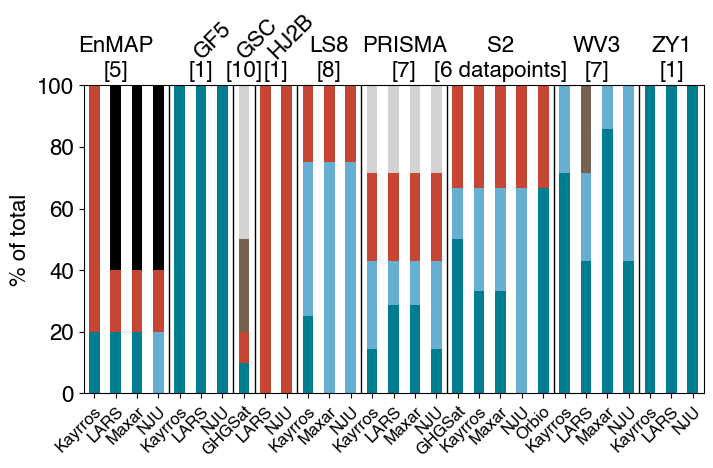

In [14]:
# Figure 1, detection plot
# Colors: https://identity.stanford.edu/design-elements/color/accent-colors/
# ['#007C92', '#67AFD2', '#C74632', '#F4795B', '#766253', '#D4D1D1']

fig, ax = plt.subplots()
#plt.font_manager._rebuild()
labelsize = 16
smalltextsize = 12
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Helvetica'})
# rc('font',**{'family':'serif','serif':['Hel vetica']})
bar1 = ax.bar(detectionFraction.index, detectionFraction['True positive'], width=0.5, ec='None', color='#007C92')
bar2 = ax.bar(detectionFraction.index, detectionFraction['False negative'], bottom=detectionFraction['True positive'], ec='None', width=0.5, color='#67AFD2')
bar3 = ax.bar(detectionFraction.index, detectionFraction['True negative'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'], ec='None', width=0.5, color='#C74632')
bar4 = ax.bar(detectionFraction.index, detectionFraction['False positive'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'] + detectionFraction['True negative'], ec='None', width=0.5, color='#F4795B')
bar5 = ax.bar(detectionFraction.index, detectionFraction['Operator filtered'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'] + detectionFraction['True negative'] + detectionFraction['False positive'], ec='None', width=0.5, color='#766253')
bar6 = ax.bar(detectionFraction.index, detectionFraction['No measurement'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'] + detectionFraction['True negative'] + detectionFraction['False positive'] + detectionFraction['Operator filtered'], ec='None', width=0.5, color='#D4D1D1')
bar7 = ax.bar(detectionFraction.index, detectionFraction['Stanford filtered'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'] + detectionFraction['True negative'] + detectionFraction['False positive'] + detectionFraction['Operator filtered'] + detectionFraction['No measurement'], ec='None', width=0.5, color='black')

# for jj in np.arange(0, detectionAccuracy.iloc[:,0].size):
#     ax.text(jj-0.14, 100.6, detectionAccuracy.iloc[jj,0], fontsize=16, color='black', rotation='horizontal') # kgh
plt.ylabel('% of total', size=labelsize)
# plt.xlabel('Team', size=16)
plt.xticks(np.arange(0, detectionAccuracy.iloc[:,0].size, 1), fontsize=smalltextsize, rotation=90)
ax.set_xticklabels(['Kayrros','LARS','Maxar','NJU','Kayrros','LARS','NJU','GHGSat', 'LARS', 'NJU', 'Kayrros', 'Maxar', 'NJU', 'Kayrros', 'LARS', 'Maxar', 'NJU', 'GHGSat', 'Kayrros', 'Maxar', 'NJU', 'Orbio', 'Kayrros', 'LARS', 'Maxar', 'NJU', 'Kayrros', 'LARS', 'NJU'], rotation=45, rotation_mode='anchor', ha='right', size=smalltextsize, color='black')
plt.text(1, 103, 'EnMAP\n['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('EnMap'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -63
plt.text(4.5, 109, 'GF5', fontsize=labelsize, color='black', rotation=45, ha='left') # -70
plt.text(5, 103, '['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('GF5'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -70
plt.text(6.5, 109, 'GSC', fontsize=labelsize, color='black', rotation=45, ha='left') # -64
plt.text(7, 103, '['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('GHGSat'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -64
plt.text(8, 109, 'HJ2B', fontsize=labelsize, color='black', rotation=45, ha='left') # -68
plt.text(8.5, 103, '['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('HJ2B'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -68
plt.text(11, 103, 'LS8\n['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('LandSat'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -55
plt.text(14.5, 103, 'PRISMA\n['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('PRISMA'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -55
plt.text(19, 103, 'S2\n['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('Sentinel-2'), 'Total included'][0]))+' datapoints]', fontsize=labelsize, color='black', rotation=0, ha='center') # -55
plt.text(23.5, 103, 'WV3\n['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('WorldView 3'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -55
plt.text(27, 103, 'ZY1\n['+str(round(detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('ZY'), 'Total included'][0]))+']', fontsize=labelsize, color='black', rotation=0, ha='center') # -55
plt.axvline(3.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(6.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(7.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(9.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(12.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(16.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(21.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(25.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.yticks(np.arange(0, 101, 20), fontsize=labelsize)
plt.ylim(0,100) # 107
plt.xlim(-0.5,28.5)
# plt.xlim(-0.5,11.5)


# plt.text(11+0.6, 100.4, '# Total', fontsize=18, color='black', rotation='horizontal') # kgh
# plt.text(-3, -20, 'Team', fontsize=20, color='black', rotation=0) # -55
# ax.legend(labels=detectionFraction.columns) # , handles=[bar1, bar2, bar3, bar4, bar5, bar6]
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
# plt.rcParams['text.usetex'] = True # http://phyletica.org/matplotlib-fonts/
# plt.rcParams['ps.fonttype'] = 42
plt.rcParams["figure.figsize"] = 8,4 # 8,4
# plt.savefig(pathlib.PurePath('02_figures', 'Detections ' + selectedTeam + ' 20230418b.png'), format='png', bbox_inches="tight")
# plt.savefig(pathlib.PurePath('02_figures', 'Detections lax' + selectedTeam + ' 20230417.png'), format='png', bbox_inches="tight")
plt.savefig(pathlib.PurePath('02_figures', 'Detections all teams 20230511b.pdf'), format='pdf', bbox_inches="tight")
# plt.savefig(pathlib.PurePath('02_figures', 'Detections all teams laxQX 20230509.png'), format='png', bbox_inches="tight")
# plt.show()

In [ ]:
detectionAccuracy.loc[detectionAccuracy['SatelliteTeam'].str.contains('EnMap'), 'Total included'][0]


# First pass at figures

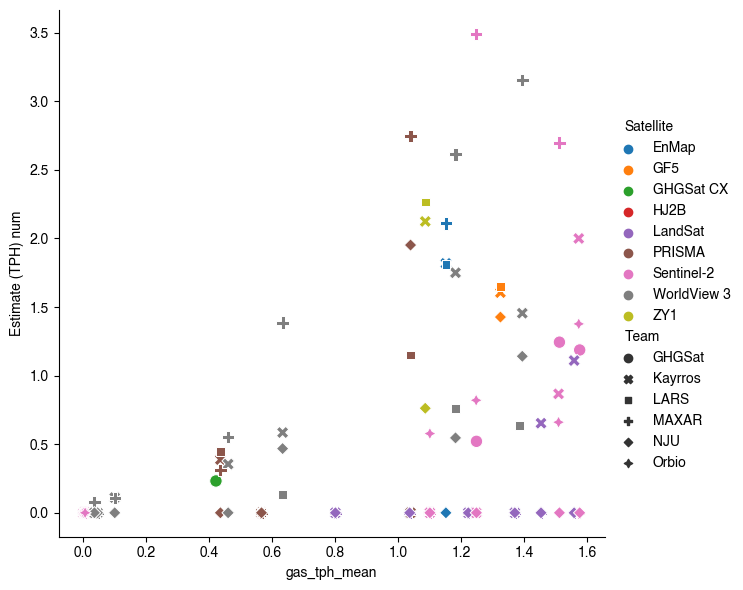

In [15]:
selectedSatelliteResultsOKQC = selectedSatelliteResults[selectedSatelliteResults['QC']=='OK']
sns.relplot(data=selectedSatelliteResultsOKQC, x='gas_tph_mean', y='Estimate (TPH) num', style='Team', hue='Satellite', s=80, kind='scatter', height=6, aspect=1.05)
# plt.xlim(-0.100,500) #7000
# plt.ylim(-0.100,500) #7000
# plt.savefig(pathlib.PurePath('02_figures', 'All-satellite parity ' + selectedTeam + ' 20230405.png'))
plt.savefig(pathlib.PurePath('02_figures', 'All-satellite parity 20230415.png'))


# Scratch pad


In [17]:
# Set color palette
# colors =  np.array(['#7F7776', '#D1660F', '#007C92', '#734675', '#C74632', 'black', 'pink', 'saddlebrown', 'green'])# np.array(['#C74632', '#D1660F', '#007C92', '#7F7776', '#734675'])[[3, 1, 2, 4, 0]]
# colorsForErrorbars = np.array(['#C74632', '#7F7776', '#D1660F', '#007C92', '#734675', 'black', 'pink', 'saddlebrown', 'green']) # np.array(['#7F7776', '#D1660F', '#007C92', '#734675', '#C74632'])
markers = np.array(['o', 'X', 's', 'P', 'd', 'v'])
# Set your custom color palette
sns.color_palette('Set2')
# StanfordPalette = sns.set_palette(sns.color_palette(colors))
# StanfordPalette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

Define function to generate parity charts

In [18]:
def parityPlot(filename, foldername = '02_figures', satellitedata=satelliteResults, satellite='All', team='All', stage=1, axisbound=6, linfitTextX = 6.750, linfitTextY = 4.200, linfitspacing = 0, qc='default', includeReg='Yes'):
    # fig = plt.gcf()
    fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [10, 1]}, figsize=(5.9, 4.9)) # (5, 4.9)
    unblindingStage = stage # 1 # 2
    selectedSatellite = satellite
    selectedTeam = team
    axistick_fontsize = 9.7 # 14
    axislabel_fontsize = 14 # 14
    legend_fontsize = axistick_fontsize # 9.5
    marker_size = 40

    # Filter for unblinding stage
    # Exclude zeros
    satellitedata = satellitedata[(satellitedata['UnblindingStage']==stage)]

    # Apply QC criteria
    if qc == 'default':
        satellitedata = satellitedata[satellitedata['QC']=='OK']
    elif qc == 'lax':
        satellitedata = satellitedata[satellitedata['QC_lax']=='OK']

    if satellite == 'All':
        if team == 'All':
            selectedSatelliteResults = satellitedata
            # selectedSatelliteResults = satellitedata[satellitedata['UnblindingStage']==unblindingStage]
    if (satellite != 'All') & (team != 'All'):
        selectedSatelliteResults = satellitedata[(satellitedata['Satellite']==selectedSatellite) & (satellitedata['Team']==selectedTeam)]
        # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
    elif satellite != 'All':
        selectedSatelliteResults = satellitedata[satellitedata['Satellite']==selectedSatellite]
        # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
    elif team != 'All':
        selectedSatelliteResults = satellitedata[satellitedata['Team']==selectedTeam]
        # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Team']==selectedTeam)]

    # Select out zeros
    selectedSatelliteResultsZeros = selectedSatelliteResults[selectedSatelliteResults['Estimate (TPH) num'] == 0]

    # Remove zeros from main data frame
    selectedSatelliteResults = selectedSatelliteResults[selectedSatelliteResults['Estimate (TPH) num'] > 0]
    # selectedSatellite = 'WV3' # 'PRISMA' # 'GHGSat C2' # 'Landsat 8' 'Sentinel-2' 'WV3'
    # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
    # selectedTeam =  'Kayrros'# 'SRON' # 'Harvard' # 'LARS'# 'GHGSat'# 'Kayrros'
    # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Team']==selectedTeam)]
    selectedSatelliteNames = selectedSatelliteResults['Satellite'].cat.categories# np.unique(selectedSatelliteResults['Satellite'])
    selectedSatellitePos = np.in1d(satelliteNames, selectedSatelliteNames) #np.where(satelliteNames == selectedSatellite)[0][0] - 1
    selectedSatelliteNames = selectedSatelliteNames.tolist()
    selectedTeamNames = selectedSatelliteResults['Team'].cat.categories# np.unique(selectedSatelliteResults['Team'])
    teamPos = np.in1d(teamNames, selectedTeamNames)
    # colors =  np.array(['#C74632', '#D1660F', '#007C92', '#7F7776', '#734675', 'black', 'pink', 'purple', 'green'])
    # slctColors = colors[selectedSatellitePos]

    # slctColorsForErrorbars = colorsForErrorbars[selectedSatellitePos]
    #
    # Uses Stanford colors: https://identity.stanford.edu/design-elements/color/accent-colors/
    colorsForErrorbars = np.array(['#016895', '#4298B5', '#734675', '#FEC51D', '#B6B1A9', '#279989', '#E98300', '#E04F39', 'black']) # #014240
    # np.array(['#007C92', '#7F7776', '#D1660F', '#734675', '#C74632', 'black', 'pink', 'saddlebrown', 'green'])
    if (satellite=='All') & (team=='All'):
        slctColorsForErrorbars =  colorsForErrorbars # colors[[4, 2, 0, 1, 3, 5, 6, 7, 8]]
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbars))# StanfordPalette = sns.set_palette(sns.color_palette(slctColors))
    elif (team!='All') & (satellite!='All'):
        slctColorsForErrorbarsInit = colorsForErrorbars[0]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit# [[1, 3, 0, 2, 4]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette([slctColorsForErrorbarsInit]))
    elif (team=='Kayrros'):
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[0, 1, 2, 3, 4, 5, 6]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    elif (team=='LARS'): # elif (team=='LARS') & (stage==1):
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[0, 1, 2, 4, 3]] # slctColorsForErrorbarsInit[[0, 1, 2, 4, 3]]
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    # elif (team=='LARS') & (stage==2):
    #     slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
    #     slctColorsForErrorbars =  slctColorsForErrorbarsInit[[0, 1, 2, 3]] # slctColorsForErrorbarsInit[[0, 1, 2, 4, 3]]
    #     StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    elif (team=='MAXAR'):
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[0, 1, 2, 3, 4]]# [[1, 3, 0, 2, 4]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    elif (team=='NJU'):
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[0, 1, 2, 3, 4, 5, 6, 7]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    elif (team=='Orbio'):
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    elif (team=='GHGSat'):
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[1, 0]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    else:
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    # if (team == 'SRON') | (team == 'Harvard') | (satellite != 'All'):
    #     slctColorsForErrorbars = np.append(slctColors[1:], slctColors[0])# slctColors# np.append(slctColors[1:], slctColors[0])
    # else: slctColorsForErrorbars = colorsForErrorbars[selectedSatellitePos]

    # slctColorsForErrorbars = colorsForErrorbars[selectedSatellitePos]

    # For main plots, LARS, and Kayrros
     # np.append(slctColors[1:], slctColors[0])# slctColors# np.append(slctColors[1:], slctColors[0])  # colorsForErrorbars[selectedSatellitePos]
    # For individual satellites and teams
    # slctColorsForErrorbars = np.append(slctColors[1:], slctColors[0])# slctColors# np.append(slctColors[1:], slctColors[0])

    subsetMarkers = np.array(['o', 'X', 's', 'P', 'd', 'v'])# np.array(['X', 's', 'P', 'd', 'o', 'v'])
    if (satellite=='All') & (team=='All'):
        slctMarkers = markers[teamPos].tolist()
    else:
        slctMarkers = subsetMarkers[teamPos].tolist()

    # Construct the main scatter plot
    mainScatterPlot = sns.scatterplot(data=selectedSatelliteResults, x='gas_tph_mean', y='Estimate (TPH) num', style='Team', hue='Satellite', markers=slctMarkers, linewidth=0, s=marker_size, ax=axes[0]) # s=80, legend=False) # 'logged KGH', palette='tab10'
    axes[0].tick_params(labelbottom=False, labelsize=axislabel_fontsize)
    axes[0].set_xlabel("")

    # mainScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
    # mainScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
    # In situ wind
    # mainScatterPlot = sns.relplot(data=satelliteResults[satelliteResults['UnblindingStage']==2], x='cr_kgh_CH4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
    lims = [0, 8.000] # [-0.100, 8.000]
    lims_df = pd.DataFrame(data={'x':lims, 'y':lims})
    sns.lineplot(data=lims_df, x='x', y='y', color='black', ax=axes[0])
    # sns.move_legend(mainScatterPlot, 'lower right', bbox_to_anchor=(0.99, 0.14)) # sns.move_legend(mainScatterPlot, 'upper left', bbox_to_anchor=(0.14, 0.99))
    # mainScatterPlot._legend.set_frame_on(True)

    # plt.errorbar(x=satelliteResults['Estimate (kgh) mean'], y=satelliteResults['Estimate (KGH) num'], xerr=meteredErrorbarsFlat, yerr=satelliteResults['Estimate (KGH) num']*0.1, fmt='.')
    # satelliteResults['Estimate (kgh) P97_5'] - satelliteResults['Estimate (kgh) mean']
    # sns.set_style("white")
    # plt.axhline(1000, ls='--', linewidth=3, color='red')
    # plt.plot([0,0], [8000,8000])
    # mainScatterPlot.ax_joint.plot([0,0], [8000,8000], '-', linewidth = 2)

    # Set axis bounds for top panel
    axes[0].set_xlim(0,axisbound) #10000 -0.100
    axes[0].set_ylim(0,axisbound) #10000 -0.100

    # plt.xlim(-0.100,axisbound) #10000
    # plt.ylim(-0.100,axisbound) #10000
    # # mainScatterPlot._legend.set_title("Satellite")
    # mainScatterPlot._legend.set_title(None)
    # mainScatterPlot._legend.remove()

    # Comment out to remove legend
    # plt.legend(bbox_to_anchor=(0.01, 1), loc='upper left', borderaxespad=0, fontsize=12)#, title_fontsize= 'large')

    # plt.legend(fontsize= 60)
    # mainScatterPlot._legend.draw_frame(True)
    # plt.xlabel('Metered emissions [t(CH$_4$)/h]', fontsize=18)
    plt.xlabel("", fontsize=axislabel_fontsize)
    plt.ylabel('Estimated emissions [t(CH$_4$)/h]', fontsize=axislabel_fontsize)
    plt.xticks(fontsize=axislabel_fontsize)
    # plt.xticks([])
    plt.yticks(fontsize=axislabel_fontsize)

    colorCounter = 0
    # shapes = itertools.cycle(['o', 'x', 's', '+', 'd'])
    for satelliteName in selectedSatelliteNames:
        selectedData = selectedSatelliteResults.loc[(selectedSatelliteResults['Satellite'] == satelliteName)]
        if len(selectedData) == 0:
            colorCounter = colorCounter + 1 # If there are no data points for the selected satellite, just advance the color counter
        else:
            slctMeteredErrorbars = selectedData[['xCILower', 'xCIUpper']] #.sub(selectedData['cr_kgh_CH4_mean300'], axis='index')
            slctMeteredErrorbarsFlat = np.concatenate(np.array(slctMeteredErrorbars)).reshape(len(slctMeteredErrorbars), 2).transpose()
            # selectedErrors = satelliteResults.loc[(satelliteResults['Satellite'] == satellite)]
            slctColor = slctColorsForErrorbars[colorCounter]
            # if (team == 'Orbio') | (satellite != 'All'):
            #     slctColor = slctColorsForErrorbars[0]
            # else:
            #     slctColor = slctColorsForErrorbars[colorCounter] #
                # slctColor = slctColorsForErrorbars[[2, 3, 1, 8, 4, 5, 0, 6, 7]][colorCounter] #

            # print(satellite)
            # print(slctColor)

            # plt.errorbar(selectedData['Estimate (kgh) mean'],
            #             selectedData['Estimate (KGH) num'], xerr=slctMeteredErrorbarsFlat, yerr=selectedData['Estimate (KGH) num']*0.1, fmt='.', color=slctColor)
            axes[0].errorbar(selectedData['gas_tph_mean'], selectedData['Estimate (TPH) num'],
                         xerr=np.array([selectedData['xCILower']*xCImult, #*xCImult
                                        selectedData['xCIUpper']*xCImult]), #*xCImult
                         # xerr=np.array([np.abs(selectedData['cr_kgh_CH4_lower300'] -
                         #                       selectedData['cr_kgh_CH4_mean300']), #*xCImult
                         #                np.abs(selectedData['cr_kgh_CH4_upper300'] -
                         #                       selectedData['cr_kgh_CH4_mean300'])]), #*xCImult
                         yerr=np.array([np.abs(selectedData['Flux est CI low'] -
                                               selectedData['Estimate (TPH) num']),
                                        np.abs(selectedData['Flux est CI high'] -
                                               selectedData['Estimate (TPH) num'])]), fmt='.', color=slctColor, alpha=0.5)
                                               # selectedData['Estimate (TPH) num'])]), fmt='.', color=slctColor, alpha=0.5)
            colorCounter = colorCounter + 1

    # plt.rcParams["figure.figsize"] = (6,5)
    #sns.set(rc={"figure.figsize":(10, 5)})
    sns.set_style("ticks") # "whitegrid" "white"

    # Linear regression for satellite data, forced zero intercept
    if (includeReg=='Yes'):
        regData = selectedSatelliteResults.loc[(selectedSatelliteResults['Estimate (TPH) num'] > 0), ['gas_tph_mean', 'Estimate (TPH) num']]
        regData.columns = ['x', 'y']
        model = smf.ols(formula="y ~ x + 0", data=regData)
        # model = smf.ols(formula="y ~ x", data=regData)
        result = model.fit()
        # result.summary()
        results_as_html_main = result.summary().tables[1].as_html()
        results_as_html_r2 = result.summary().tables[0].as_html()
        # results_as_html
        results_main = pd.read_html(results_as_html_main, header=0, index_col=0)[0]
        results_r2_and_more = pd.read_html(results_as_html_r2, header=0, index_col=0)[0]
        results_r2 = str(np.abs(float(results_r2_and_more.columns[2]))) # Prevent the possibility of a -0 R squared by doing absolute value
        results_coeff = results_main['coef'][0]

        x_domain = np.array([lims[0], lims[1]]) #.reshape(-1,1)
        y_pred = x_domain*results_coeff
        xy_df = pd.DataFrame(data={'x':x_domain, 'y':y_pred})

        sns.lineplot(data=xy_df, x='x', y='y', color='gray', dashes=[2, 2], ax=axes[0]) # , style='-'
        # axes[0].plot(x_domain, y_pred, '-', color='gray', linewidth=3)
        axes[0].text(linfitTextX+0.02, linfitTextY, 'y='+str(np.round(results_coeff, 3))+'x', fontsize=axislabel_fontsize, color='gray', rotation=0, ha='left') # -63
        axes[0].text(linfitTextX, linfitTextY - 0.25 - linfitspacing, 'R$^2$='+results_r2, fontsize=axislabel_fontsize, color='gray', rotation=0, ha='left') # -63
    # For in situ wind case
    # plt.text(6750, 5000, 'y='+str(np.round(results_coeff, 3))+'x', fontsize=18, color='gray', rotation=0, ha='right') # -63
    # plt.text(6600, 4500, 'R$^2$='+results_r2, fontsize=18, color='gray', rotation=0, ha='right') # -63

    # plt.tight_layout()

    # Save strip of zeros

    zerosPlot = sns.scatterplot(data=selectedSatelliteResultsZeros, x='gas_tph_mean', y='Estimate (TPH) num', style='Team', hue='Satellite', markers=slctMarkers, s=marker_size, alpha=0.4, legend=False, ax=axes[1]) # 'logged KGH', palette='tab10' height=0.3, aspect=17
    detect_plot_strip_width = 0.01
    axes[1].set_xlim(0,axisbound)
    # plt.gcf().patch.set_edgecolor('black')
    axes[1].set_ylim(-detect_plot_strip_width, detect_plot_strip_width)
    # plt.xlabel('Metered emissions [t(CH$_4$)/h]', fontsize=14)
    plt.xticks(fontsize=axistick_fontsize)
    # zerosPlot.set(ylabel=None)

    # Set axis ticks
    sns.set_style("ticks")
    ticklabels = np.arange(0, axisbound + 0.5, 0.5)
    axes[0].set_xticks(ticklabels)
    axes[0].set_yticks(ticklabels)
    axes[0].set_xticklabels(ticklabels, fontsize=axistick_fontsize)
    axes[0].set_yticklabels(ticklabels, fontsize=axistick_fontsize)
    axes[1].set_yticklabels(['', 0.0, ''], fontsize=axistick_fontsize)

    # Set axis labels
    axes[1].set_xlabel('Metered emissions [t(CH$_4$)/h]', size=axislabel_fontsize)
    axes[0].set_ylabel('Estimated emissions\n[t(CH$_4$)/h]', size=axislabel_fontsize)
    axes[1].set_ylabel('Non-\ndetects', size=16)

    # leg = axes[0].legend()
    # leg.get_frame().set_edgecolor('black')
    axes[0].legend(loc = 'upper left', bbox_to_anchor=(1.02, 1.03), fontsize=legend_fontsize, edgecolor='black')# , mode='expand', borderaxespad=0.) # (1.02, 1.03)

    plt.tight_layout()
    # plt.savefig(pathlib.PurePath(foldername, 'Zeros' + filename), format='png')
    plt.savefig(pathlib.PurePath(foldername, filename), format='pdf')

    # plt.show()

/Users/evansherwin/PycharmProjects/MethaneDistributions/ven/lib/python3.7/site-packages/ipykernel_launcher.py:246: UserWarning: FixedFormatter should only be used together with FixedLocator
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven/lib/python3.7/site-packages/ipykernel_launcher.py:246: UserWarning: FixedFormatter should only be used together with FixedLocator


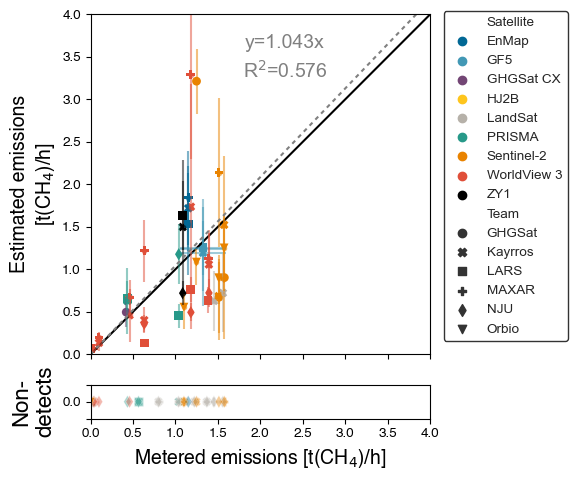

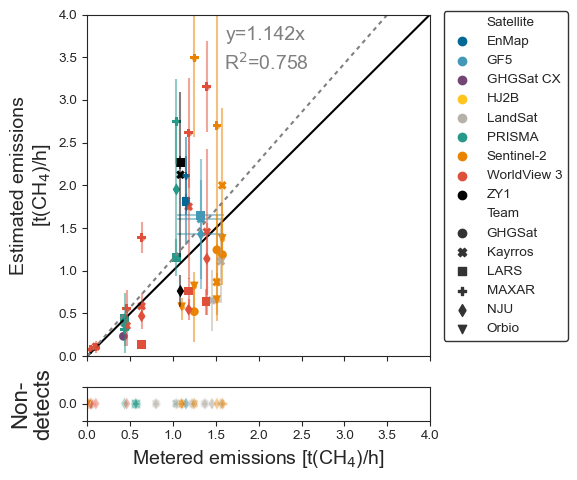

In [19]:
# Generate parity plots

# Stage 1
# parityPlot(filename='Satellite parity stage 1 20230509.png', axisbound=8, linfitTextX=3.6, linfitTextY=7.2, linfitspacing=0.5, satellitedata=satelliteResults)
parityPlot(filename='Satellite parity stage 1 zoom 20230511.pdf', axisbound=4, linfitTextX=1.8, linfitTextY=3.6, linfitspacing=0.1, satellitedata=satelliteResults)
#
# # Stage 2
# parityPlot(filename='Satellite parity stage 2 20230509.png', axisbound=8, linfitTextX=3.2, linfitTextY=7.4, linfitspacing=0.5, satellitedata=satelliteResults, stage=2)
parityPlot(filename='Satellite parity stage 2 zoom 20230511.pdf', axisbound=4, linfitTextX=1.6, linfitTextY=3.7, linfitspacing=0.1, satellitedata=satelliteResults, stage=2)

/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: V

<Figure size 600x500 with 0 Axes>

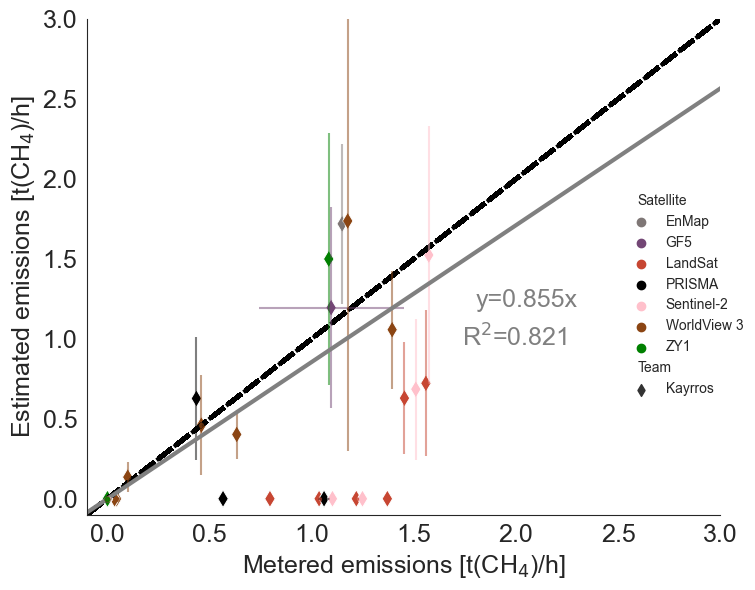

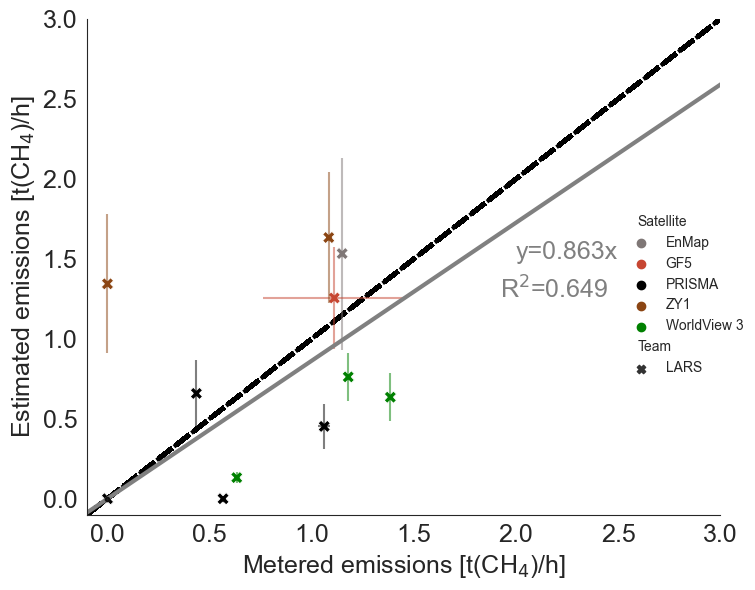

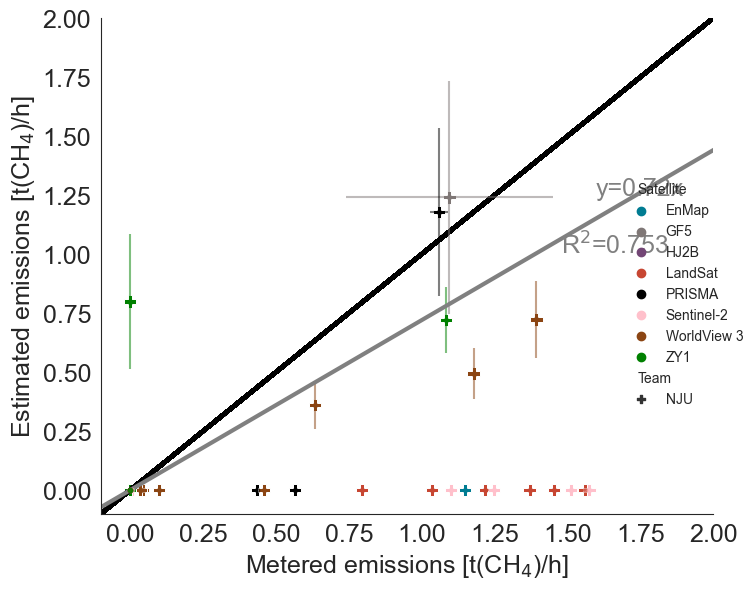

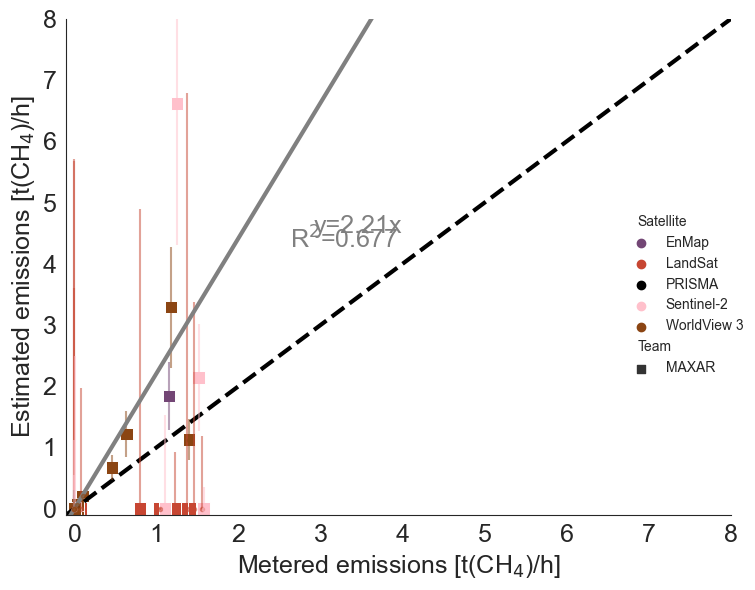

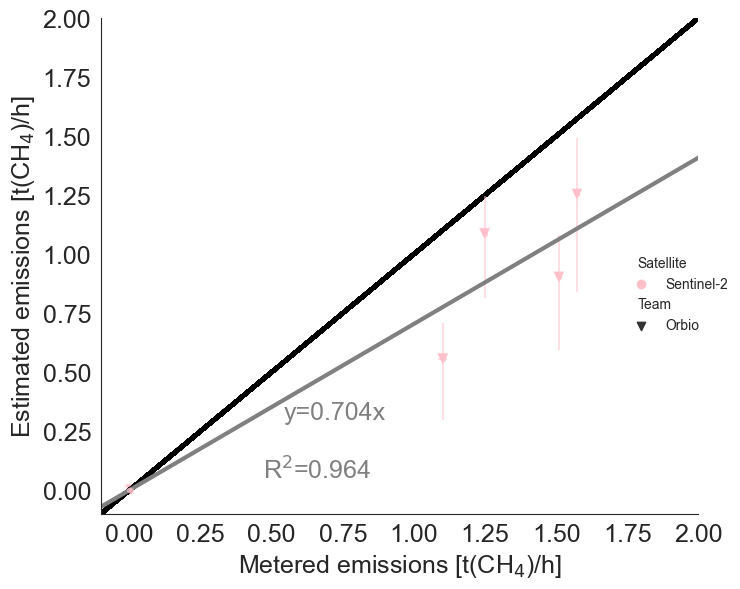

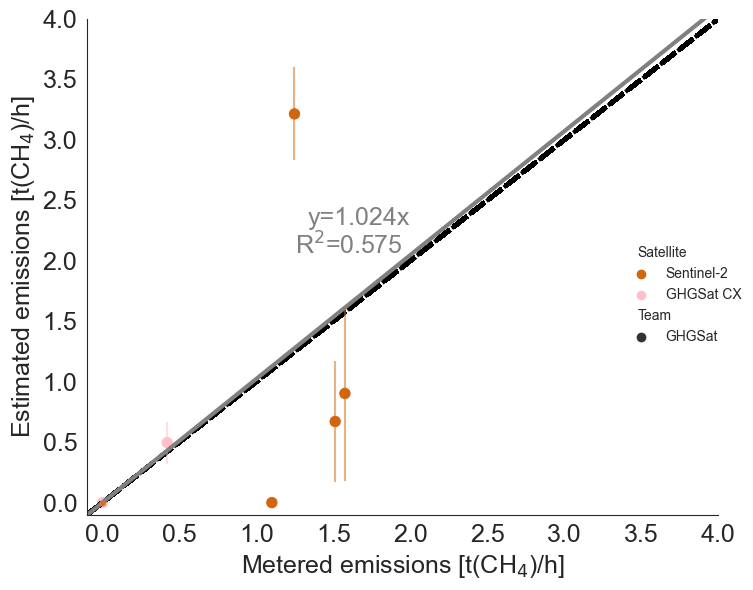

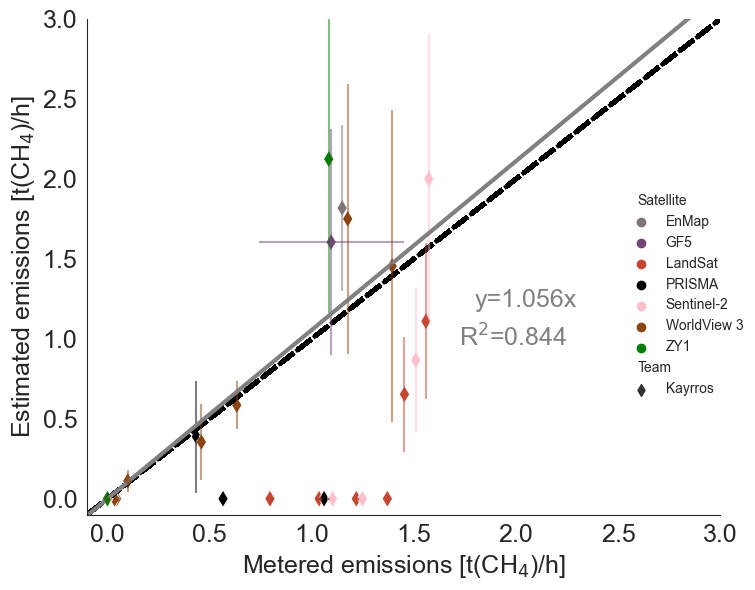

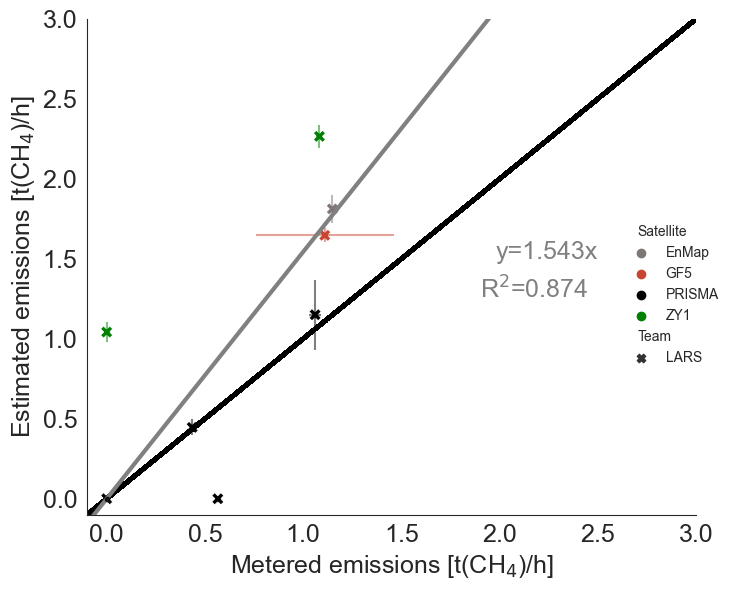

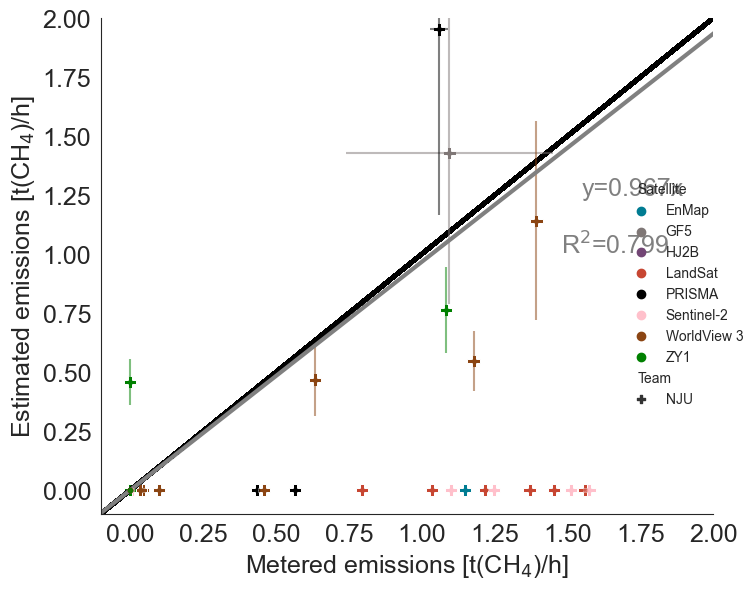

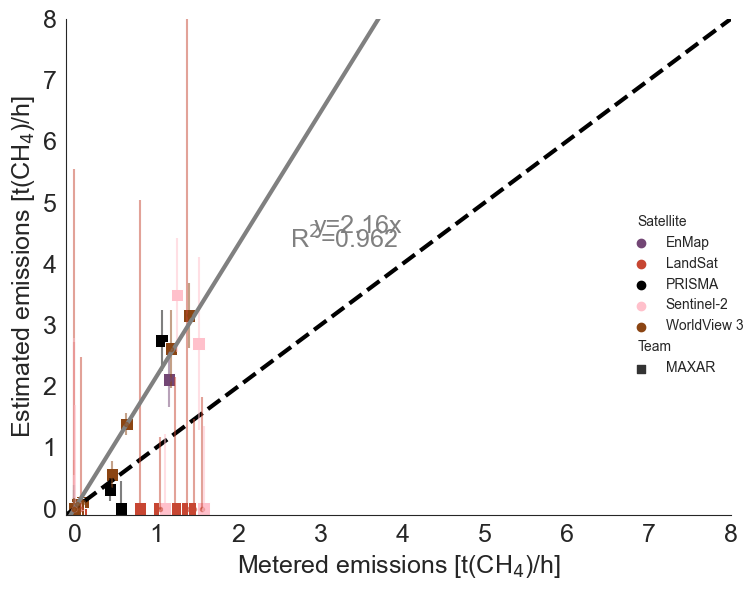

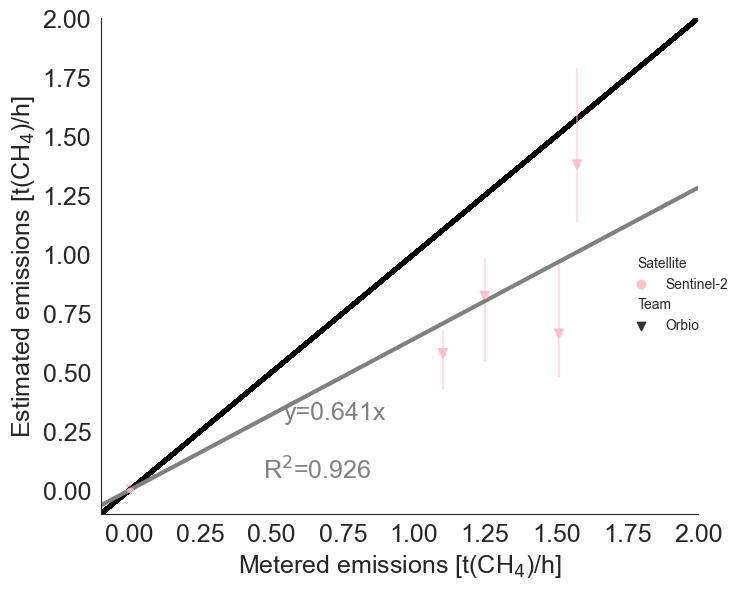

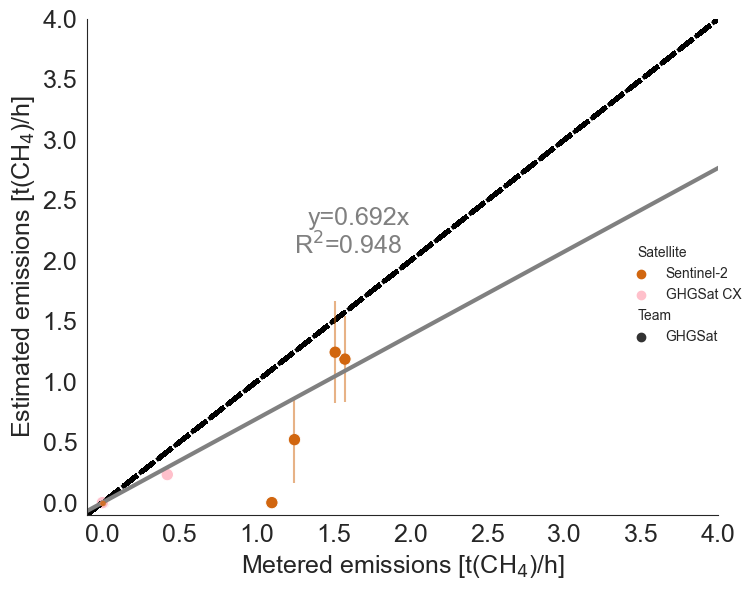

In [386]:
# Results with full QC

# Stage 1
parityPlot(filename='Satellite Kayrros stage 1 20230509.png', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.3, linfitTextY=1.2, team='Kayrros')
parityPlot(filename='Satellite LARS stage 1 20230509.png', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.5, linfitTextY=1.5, team='LARS')
parityPlot(filename='Satellite NJU stage 1 20230509.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=1.9, linfitTextY=1.25, team='NJU')
parityPlot(filename='Satellite MAXAR stage 1 20230509.png', satellitedata=satelliteResults, axisbound=8, linfitTextX=4, linfitTextY=4.5, team='MAXAR')
parityPlot(filename='Satellite Orbio stage 1 20230509.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.9, linfitTextY=0.3, team='Orbio')
parityPlot(filename='Satellite GHGSat stage 1 20230509.png', satellitedata=satelliteResults, axisbound=4, linfitTextX=2, linfitTextY=2.3, team='GHGSat')

# Stage 2
parityPlot(filename='Satellite Kayrros stage 2 20230509.png', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.3, linfitTextY=1.2, team='Kayrros', stage=2)
parityPlot(filename='Satellite LARS stage 2 20230509.png', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.5, linfitTextY=1.5, team='LARS', stage=2)
parityPlot(filename='Satellite NJU stage 2 20230509.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=1.9, linfitTextY=1.25, team='NJU', stage=2)
parityPlot(filename='Satellite MAXAR stage 2 20230509.png', satellitedata=satelliteResults, axisbound=8, linfitTextX=4, linfitTextY=4.5, team='MAXAR', stage=2)
parityPlot(filename='Satellite Orbio stage 2 20230509.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.9, linfitTextY=0.3, team='Orbio', stage=2)
parityPlot(filename='Satellite GHGSat stage 2 20230509.png', satellitedata=satelliteResults, axisbound=4, linfitTextX=2, linfitTextY=2.3, team='GHGSat', stage=2)

/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 

<Figure size 640x480 with 0 Axes>

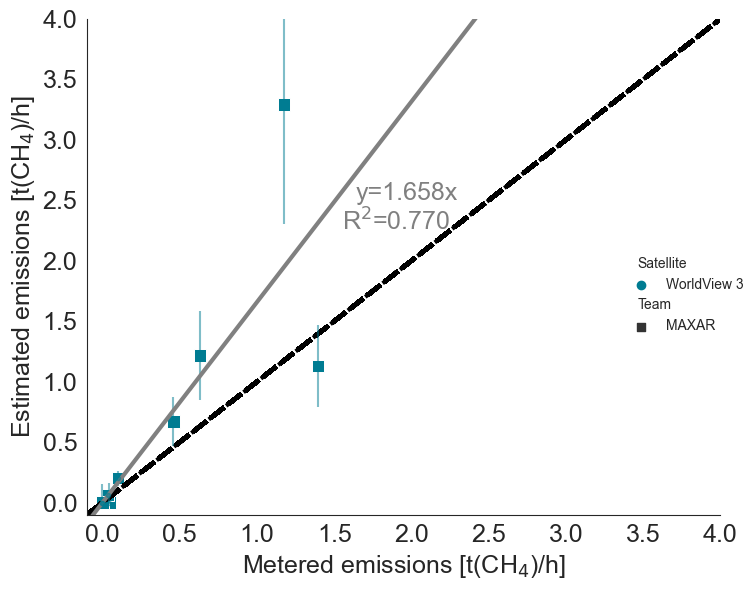

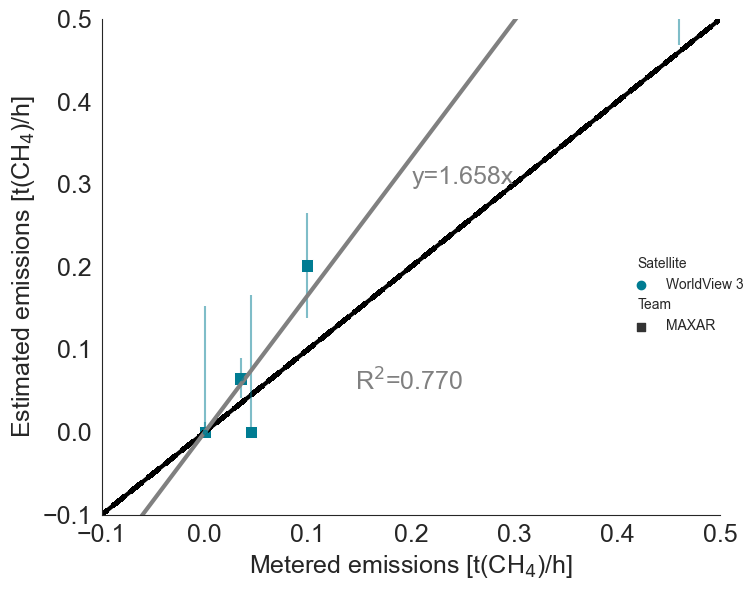

In [171]:
# Results by satellite
# With full QC

# Stage 1
parityPlot(filename='Satellite Sentinel-2 stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=8, linfitTextX=1.5, linfitTextY=6, linfitspacing=0.5, satellite='Sentinel-2')
parityPlot(filename='Satellite GHGSat stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=3, linfitTextX=0.2, linfitTextY=1.6, linfitspacing=0.1, satellite='GHGSat CX', includeReg='No')
parityPlot(filename='Satellite EnMAP stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.2, linfitTextY=1.6, linfitspacing=-0.05, satellite='EnMap')
parityPlot(filename='Satellite GF5 stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.75, linfitTextY=0.4, linfitspacing=-0.05, satellite='GF5')
parityPlot(filename='Satellite LandSat stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.6, linfitTextY=0.2, linfitspacing=-0.05, satellite='LandSat')
parityPlot(filename='Satellite PRISMA stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=1.2, linfitTextY=0.9, linfitspacing=-0.05, satellite='PRISMA')
parityPlot(filename='Satellite WorldView 3 stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=4, linfitTextX=2, linfitTextY=1.7, linfitspacing=0.1, satellite='WorldView 3')
parityPlot(filename='Satellite ZY1 stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=4, linfitTextX=0.5, linfitTextY=3, linfitspacing=0.1, satellite='ZY1')
parityPlot(filename='Satellite HJ2B stage 1 20230509b.png', satellitedata=satelliteResults, axisbound=4, linfitTextX=2, linfitTextY=2.3, linfitspacing=0.1, satellite='HJ2B', includeReg='No')
#

<ErrorbarContainer object of 3 artists>

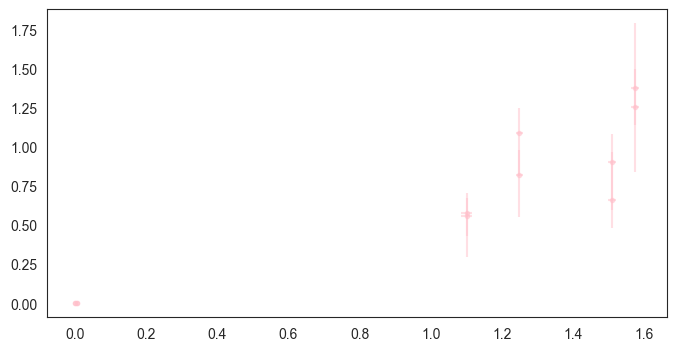

In [239]:
# Results with lax QC

# Stage 1
parityPlot(filename='Satellite Kayrros laxqc stage 1 20230509.png', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.3, linfitTextY=1.2, team='Kayrros', qc='lax')
parityPlot(filename='Satellite LARS laxqc stage 1 20230509.png', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.5, linfitTextY=1.5, team='LARS', qc='lax')
parityPlot(filename='Satellite NJU laxqc stage 1 20230509.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=1.9, linfitTextY=1.25, team='NJU', qc='lax')
parityPlot(filename='Satellite MAXAR laxqc stage 1 20230509.png', satellitedata=satelliteResults, axisbound=8, linfitTextX=4, linfitTextY=4.5, team='MAXAR', qc='lax')
parityPlot(filename='Satellite Orbio laxqc stage 1 20230509.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.9, linfitTextY=0.3, team='Orbio', qc='lax')
parityPlot(filename='Satellite GHGSat laxqc stage 1 20230509.png', satellitedata=satelliteResults, axisbound=4, linfitTextX=2, linfitTextY=2.3, team='GHGSat', qc='lax')

# Stage 2
parityPlot(filename='Satellite Kayrros laxqc stage 2 20230509.png', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.3, linfitTextY=1.2, team='Kayrros', stage=2, qc='lax')
parityPlot(filename='Satellite LARS laxqc stage 2 20230509.png', satellitedata=satelliteResults, axisbound=3, linfitTextX=2.5, linfitTextY=1.5, team='LARS', stage=2, qc='lax')
parityPlot(filename='Satellite NJU laxqc stage 2 20230509.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=1.9, linfitTextY=1.25, team='NJU', stage=2, qc='lax')
parityPlot(filename='Satellite MAXAR laxqc stage 2 20230509.png', satellitedata=satelliteResults, axisbound=8, linfitTextX=4, linfitTextY=4.5, team='MAXAR', stage=2, qc='lax')
parityPlot(filename='Satellite Orbio laxqc stage 2 20230509.png', satellitedata=satelliteResults, axisbound=2, linfitTextX=0.9, linfitTextY=0.3, team='Orbio', stage=2, qc='lax')
parityPlot(filename='Satellite GHGSat laxqc stage 2 20230509.png', satellitedata=satelliteResults, axisbound=4, linfitTextX=2, linfitTextY=2.3, team='GHGSat', stage=2, qc='lax')


In [ ]:
parityPlot(filename='Satellite MAXAR WV3 stage 1 20230415.png'), satellitedata=satelliteResults, axisbound=4, linfitTextX=2.3, linfitTextY=2.5, team='MAXAR', satellite='WorldView 3')
parityPlot(filename='Satellite MAXAR WV3 zoom stage 1 20230415.png'), satellitedata=satelliteResults, axisbound=0.5, linfitTextX=0.3, linfitTextY=0.3, team='MAXAR', satellite='WorldView 3')
parityPlot(filename='Satellite MAXAR WV3 stage 2 20230415.png'), satellitedata=satelliteResults, axisbound=4, linfitTextX=2.3, linfitTextY=2.5, team='MAXAR', satellite='WorldView 3', stage=2)
parityPlot(filename='Satellite MAXAR WV3 zoom stage 2 20230415.png'), satellitedata=satelliteResults, axisbound=0.5, linfitTextX=0.3, linfitTextY=0.3, team='MAXAR', satellite='WorldView 3', stage=2)


Percent quantification error, Figure S2

In [ ]:
# Figure S2, percent quantification error
# To produce Stage 2 estimates, switch unblindingStage from 1 to 2

def errorPlot(filename, satellitedata=satelliteResults, satellite='All', team='All', stage=1, axisbound=200, qc='default'):

    fig = plt.gcf()
    unblindingStage = stage # 1 # 2
    selectedSatellite = satellite
    selectedTeam = team

    # Filter for unblinding stage
    satellitedata = satellitedata[satellitedata['UnblindingStage']==stage]

    # Apply QC criteria
    if qc == 'default':
        satellitedata = satellitedata[satellitedata['QC']=='OK']
    elif qc == 'lax':
        satellitedata = satellitedata[satellitedata['QC_lax']=='OK']

    if satellite == 'All':
        if team == 'All':
            selectedSatelliteResults = satellitedata
            # selectedSatelliteResults = satellitedata[satellitedata['UnblindingStage']==unblindingStage]
    if (satellite != 'All') & (team != 'All'):
        selectedSatelliteResults = satellitedata[(satellitedata['Satellite']==selectedSatellite) & (satellitedata['Team']==selectedTeam)]
        # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
    elif satellite != 'All':
        selectedSatelliteResults = satellitedata[satellitedata['Satellite']==selectedSatellite]
        # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
    elif team != 'All':
        selectedSatelliteResults = satellitedata[satellitedata['Team']==selectedTeam]
        # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Team']==selectedTeam)]

    # Percent change
    pctScatterPlot = sns.relplot(data=selectedSatelliteResults, x='gas_tph_mean', y='Error num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter') #, legend=False)
    # In situ wind
    # pctScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Error in situ wind num', style='Team', hue='Satellite', s=80, kind='scatter') #, legend=False)
    # sns.move_legend(mainScatterPlot, 'upper left', bbox_to_anchor=(0.8, 0.99))
    sns.set_style("white")
    plt.xlim(0,2)
    # plt.ylim(-103,150)
    pctScatterPlot._legend.set_title("Satellite")
    # mainScatterPlot._legend.draw_frame(True)
    pctScatterPlot._legend.set_frame_on(True)
    # pctScatterPlot._legend.remove()
    plt.xlabel('Metered emissions [t(CH4)/h]', fontsize=18)
    plt.ylabel('Error [%]', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.rcParams["figure.figsize"] = (6,5)
    # ax.get_yaxis().set_major_formatter(
    #     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    # ax.get_xaxis().set_major_formatter(
    #     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))# sns.set_style('darkgrid', {'legend.frameon':True})
    # plt.savefig('/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity error stage 1 20230118.pdf', format='pdf')
    # plt.savefig('/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity error stage 2 20230118.pdf', format='pdf')
    plt.savefig(filename, format='png')
    plt.show()

In [19]:
# errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors Kayrros stage 1 20230416.png'), satellitedata=satelliteResults, team='Kayrros')

# Stage 1
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors Kayrros stage 1 20230417.png'), satellitedata=satelliteResults, team='Kayrros')
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors LARS stage 1 20230417.png'), satellitedata=satelliteResults, team='LARS')
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors NJU stage 1 20230417.png'), satellitedata=satelliteResults, team='NJU')
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors MAXAR stage 1 20230417.png'), satellitedata=satelliteResults, team='MAXAR')
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors Orbio stage 1 20230417.png'), satellitedata=satelliteResults, team='Orbio')
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors GHGSat stage 1 20230417.png'), satellitedata=satelliteResults, team='GHGSat')

# Stage 2
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors Kayrros stage 2 20230417.png'), satellitedata=satelliteResults, team='Kayrros', stage=2)
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors LARS stage 2 20230417.png'), satellitedata=satelliteResults, team='LARS', stage=2)
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors NJU stage 2 20230417.png'), satellitedata=satelliteResults, team='NJU', stage=2)
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors MAXAR stage 2 20230417.png'), satellitedata=satelliteResults, team='MAXAR', stage=2)
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors Orbio stage 2 20230417.png'), satellitedata=satelliteResults, team='Orbio', stage=2)
errorPlot(filename=pathlib.PurePath('02_figures', 'Satellite errors GHGSat stage 2 20230417.png'), satellitedata=satelliteResults, team='GHGSat', stage=2)


,cr_kgh_CH4_mean300,Wind_MPS_mean60,Wind_MPS_sd60,Wind_dir_mean60,Wind_dir_sd60
Sentinel-2,3.5,4.3,0.7,57.0,15.4
Landsat 8,4.2,4.0,0.9,48.8,7.8
PRISMA,4.5,3.7,0.7,38.9,5.2
WorldView 3,4.0,3.9,0.7,243.0,10.4
GHGSat C2,4.2,2.0,0.4,264.1,10.8


Metered emission rate, wind speed, and wind direction for emissions from Figure 2

<Figure size 432x288 with 0 Axes>

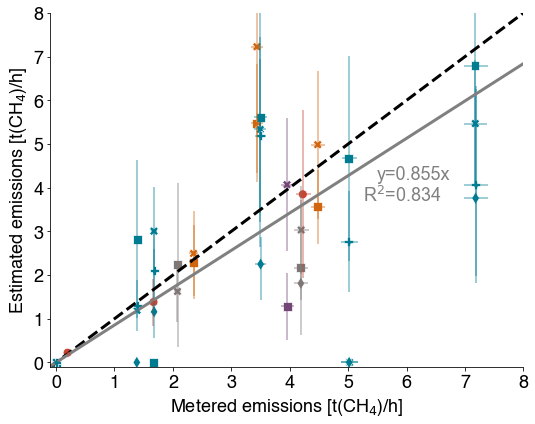

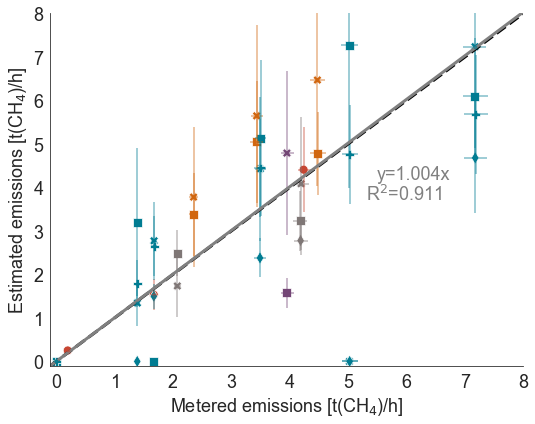

In [37]:
# Key values for Figure 2

key_fig2_cols = ["cr_kgh_CH4_mean300", "Wind_MPS_mean60", "Wind_MPS_sd60", "Wind_dir_mean60", "Wind_dir_sd60"]
Figure2_vals = pd.DataFrame(selectedSatelliteResults.loc[(selectedSatelliteResults["Stanford_timestamp"]=="2021-10-27 18:34:57+00:00") & (selectedSatelliteResults["OperatorSet"]=="Sentinel-2/Kayrros"), key_fig2_cols])
Figure2_vals = Figure2_vals.append(selectedSatelliteResults.loc[(selectedSatelliteResults["Stanford_timestamp"]=="2021-10-21 18:10:37+00:00") & (selectedSatelliteResults["OperatorSet"]=="Landsat 8/Kayrros"), key_fig2_cols])
Figure2_vals = Figure2_vals.append(selectedSatelliteResults.loc[(selectedSatelliteResults["Stanford_timestamp"]=="2021-10-21 18:23:12+00:00") & (selectedSatelliteResults["OperatorSet"]=="PRISMA/Kayrros"), key_fig2_cols])
Figure2_vals = Figure2_vals.append(selectedSatelliteResults.loc[(selectedSatelliteResults["Stanford_timestamp"]=="2021-10-23 18:40:53+00:00") & (selectedSatelliteResults["OperatorSet"]=="WV3/Kayrros"), key_fig2_cols])
Figure2_vals = Figure2_vals.append(selectedSatelliteResults.loc[(selectedSatelliteResults["Stanford_timestamp"]=="2021-10-24 17:35:19+00:00") & (selectedSatelliteResults["OperatorSet"]=="GHGSat C2/GHGSat"), key_fig2_cols])
Figure2_vals.index = ["Sentinel-2", "Landsat 8", "PRISMA", "WorldView 3", "GHGSat C2"]
np.round(Figure2_vals, 1)

Generate parity charts, including Figure 3

In [ ]:
# Figure 3 and Figure S1 (to generate 95% CI, set yCImult = 1.96)
# Plots for stages 1 and 2
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity stage 1 20230118.pdf', satellitedata=satelliteResults, stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity stage 2 20230118.pdf', satellitedata=satelliteResults, stage=2)
# parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity stage 1 95% CI 20230118.pdf', satellitedata=satelliteResults, stage=1)
# parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity stage 2 95% CI 20230118.pdf', satellitedata=satelliteResults, stage=2)

In [ ]:
# Figure S4, parity charts by team

parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity Kayrros 20230116c.pdf', satellitedata=satelliteResults, team='Kayrros', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity SRON 20230116c.pdf', satellitedata=satelliteResults, team='SRON', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity Harvard 20231016c.pdf', satellitedata=satelliteResults, team='Harvard', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity LARS 20230116c.pdf', satellitedata=satelliteResults, team='LARS', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity GHGSat 20230116c.pdf', satellitedata=satelliteResults, team='GHGSat', stage=1)

In [36]:
# Figure S5, parity charts by satellite

parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity Sentinel-2 20230116c.pdf', satellitedata=satelliteResults, satellite='Sentinel-2', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity Landsat 8 20230116c.pdf', satellitedata=satelliteResults, satellite='Landsat 8', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity PRISMA 20230116c.pdf', satellitedata=satelliteResults, satellite='PRISMA', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity GHGSat C2 20230116c.pdf', satellitedata=satelliteResults, satellite='GHGSat C2', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity WV3 20230116c.pdf', satellitedata=satelliteResults, satellite='WV3', stage=1)

count    44.000000
mean      0.112608
std       0.006102
min       0.101474
25%       0.109074
50%       0.112926
75%       0.116130
max       0.127175
dtype: float64

Key additional results in the manuscript

In [35]:
# Max % error in metered emission rate
# satelliteResults
((selectedSatelliteResults['cr_kgh_CH4_upper300'] - selectedSatelliteResults['cr_kgh_CH4_lower300'])/satelliteResults['cr_kgh_CH4_mean300']).describe()
# max(abs(((satelliteResults['x95pctCIUpper'] - satelliteResults['x95pctCILower'])/satelliteResults['cr_kgh_CH4_mean300'])))
# satelliteResults[['x95pctCIUpper','x95pctCILower']]


(24, 32, 0.75)

In [ ]:
# Min and max % error in estimates
selectedSatelliteResults.loc[selectedSatelliteResults['Error num'] > -100, 'Error num'].describe()

In [198]:
# Error statistics, percent of detected emissions with Stage 1 absolute error below 50%
selectedSatelliteResults.loc[selectedSatelliteResults['Error num'] > -100, 'Error num'].describe()
detectedResults = selectedSatelliteResults.loc[selectedSatelliteResults['Error num'] > -100, 'Error num'].size
detectedResultsUnder50 = (abs(selectedSatelliteResults.loc[selectedSatelliteResults['Error num'] > -100, 'Error num']) < 50).sum()
detectedResultsUnder50, detectedResults, detectedResultsUnder50/detectedResults

0.868421052631579

Comparison with Kairos controlled releases, discussed in SI, Section S4

In [ ]:
# Kairos controlled releases with error less than ±50%
# Downloaded from https://github.com/yuliachen/Single-blind-test-of-airplane-based-hyperspectral-methane-detection-via-controlled-releases/blob/master/github_version/Stanford_Kairos_controlled_release_2019_studyData.xlsx
# Reproduced with permission from Sherwin, Chen et al. 2021
# https://online.ucpress.edu/elementa/article/doi/10.1525/elementa.2021.00063/116576/Single-blind-test-of-airplane-based-hyperspectral
# Discussed further in the SI, Section S4

kairos_CR_data = pd.read_excel('/Users/evansherwin/PycharmProjects/SatelliteTesting/Data/Stanford_Kairos_controlled_release_2019_studyData.xlsx', sheet_name="DATA", engine = 'openpyxl', skiprows=1 )
molCH4_per_mol_NG = 0.935 # Sherwin, Chen et al. 2021
kairos_estimate_mcfd_mph_CH4 = kairos_CR_data['closest_plume_quantification_mcfdmph']
metered_estimate_mcfd_mph_CH4 = kairos_CR_data['total_release_mcfd']*molCH4_per_mol_NG/kairos_CR_data['WS_windGust_logged_mph']
kairos_estimate_pct_err =  100*(kairos_estimate_mcfd_mph_CH4 - metered_estimate_mcfd_mph_CH4)/metered_estimate_mcfd_mph_CH4
# Exclude non-detects
kairos_quantified_pct_err = kairos_estimate_pct_err[np.isnan(kairos_estimate_pct_err)==False]
# Number of errors between ±50%
np.mean(np.abs(kairos_quantified_pct_err) <= 50)

In [ ]:
# Fraction of Stage 1 satellite errors between ±50%
unblindingStage = 1 # 2
selectedSatelliteErr = satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100), 'Error num']
np.mean(np.abs(selectedSatelliteErr) < 50)


Parity linear regression results from Figure 3

In [ ]:
# Linear regression for Stage 1 satellite data, forced zero intercept, excluding non-detects
unblindingStage = 1 # 2
floorQuantificationEstimate = 0 # Exclude all emissions less than or equal to this from the regression analysis
selectedSatelliteResults = satelliteResults[satelliteResults['UnblindingStage']==unblindingStage]
include_intercept=False # True False
X = np.array(selectedSatelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > floorQuantificationEstimate), 'cr_kgh_CH4_mean300']).reshape(-1,1)
y = np.array(selectedSatelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > floorQuantificationEstimate), 'Estimate (KGH) num']).reshape(-1,1)
reg_stage1 = sm.OLS(y, X).fit()
reg_stage1.summary()
# reg_stage1 = LinearRegression(fit_intercept=include_intercept).fit(X, y)
# reg_stage1.coef_, reg_stage1.intercept_, reg_stage1.score(X, y)

In [ ]:
# Linear regression results for Stage 1 satellite data, floating intercept, excluding non-detects
reg_float_intercept = LinearRegression(fit_intercept=True).fit(X, y)
reg_float_intercept.coef_, reg_float_intercept.intercept_, reg_float_intercept.score(X, y)

In [ ]:
# Linear regression for Stage 2 satellite data, forced zero intercept, excluding non-detects
unblindingStage = 2
floorQuantificationEstimate = 0 # Exclude all emissions less than or equal to this from the regression analysis
selectedSatelliteResults = satelliteResults[satelliteResults['UnblindingStage']==unblindingStage]
include_intercept=False # True False
X = np.array(selectedSatelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > floorQuantificationEstimate), 'cr_kgh_CH4_mean300']).reshape(-1,1)
y = np.array(selectedSatelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > floorQuantificationEstimate), 'Estimate (KGH) num']).reshape(-1,1)
reg_stage2 = sm.OLS(y, X).fit()
reg_stage2.summary()
# reg_stage2 = LinearRegression(fit_intercept=include_intercept).fit(X, y)
# reg_stage2.coef_, reg_stage2.intercept_, reg_stage2.score(X, y)

Confidence interval calibration assessment

In [71]:
# Fraction estimates with CI overlapping parity line
# For 95% CI results, update the yCImult parameter to 1.96
CI_overlapping_parity = satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100), 'within CI']==True
np.sum(CI_overlapping_parity)/CI_overlapping_parity.size

0   -17.140810
2    -8.889579
4    12.992303
Name: Error num, dtype: float64

Percent error values from GHGSat

In [72]:
# GHGSat errors
selectedSatelliteErrGHGSat = (satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100) & (satelliteResults['Team'] == 'GHGSat'), 'Error num'])
selectedSatelliteErrGHGSat

Fraction of Permian emissions satellites would see, discussed in SI, Section S5

In [74]:
# Analysis of data from Chen, Sherwin et al. 2022
# Data reproduced with permission
# https://pubs.acs.org/doi/10.1021/acs.est.1c06458
# Discussed further in the SI, Section S5

permianPlumes = pd.read_csv('/Users/evansherwin/PycharmProjects/SatelliteTesting/Data/Chen, Sherwin et al 2022 plume_table.csv')
permianPlumes['emissions_kgh'] = permianPlumes['wind_independent_emission_rate_kghmps']*permianPlumes['wind_mps']
permianPlumes['emissions>=5tph'] = permianPlumes['emissions_kgh'] >= 5000
permianPlumes['emissions>=1tph'] = permianPlumes['emissions_kgh'] >= 1000
permianPlumes['emissions>=0_5tph'] = permianPlumes['emissions_kgh'] >= 500
permianPlumes['emissions>=0_1tph'] = permianPlumes['emissions_kgh'] >= 100
emissions_gr_cols = ['emissions>=5tph', 'emissions>=1tph', 'emissions>=0_5tph', 'emissions>=0_1tph']

176.928

In [75]:
# Plumes detected in each case
np.sum(permianPlumes[emissions_gr_cols])

emissions>=5tph      0.005542
emissions>=1tph      0.058942
emissions>=0_5tph    0.129975
emissions>=0_1tph    0.595466
dtype: float64

In [76]:
# Estimated total New Mexico Permian emissions
total_NM_Permian_emissions = 194 # t/h
surveyed_NM_Permian_asset_frac = 0.912 # Fraction of active wells surveyed
surveyed_NM_Permian_emissions = total_NM_Permian_emissions*surveyed_NM_Permian_asset_frac
surveyed_NM_Permian_emissions

emissions>=5tph      0.191452
emissions>=1tph      0.468582
emissions>=0_5tph    0.607410
emissions>=0_1tph    0.891211
dtype: float64

In [ ]:
# Fraction of plumes detected in each case
np.mean(permianPlumes[emissions_gr_cols])

In [70]:
# Fraction of total emissions volume detected in each case
# Assumes 4 measurements per asset, the average across the campaign, to account for persistence
measurements_per_asset = 4
# np.sum(permianPlumes[emissions_gr_cols].multiply(permianPlumes['emissions_kgh'], axis=0))/np.sum(permianPlumes['emissions_kgh'])
np.sum(permianPlumes[emissions_gr_cols].multiply(permianPlumes['emissions_kgh'], axis=0))/(measurements_per_asset*surveyed_NM_Permian_emissions*kg_per_t)

86    -14.080435
87    103.445597
88     -6.299117
89   -100.000000
Name: Error num, dtype: float64

Quantification accuracy for the smallest Sentinel-2 release

In [153]:
# Quantification accuracy for the smallest Sentinel-2 release
satelliteResults.loc[(satelliteResults['Stanford_timestamp'] == '2021-11-03 18:25:01+00:00') & (satelliteResults['UnblindingStage'] == 1), 'Error num']


,count,min,mean,max,std
Satellite,,,,,
GHGSat C2,3,-8.209268,7.946916,27.998210,18.415327
Landsat 8,5,-33.561941,-11.055090,19.878627,20.607909
PRISMA,6,6.854812,44.498127,64.470808,20.414444
Sentinel-2,16,-34.762921,19.288769,130.784948,43.470432
WV3,2,-60.065091,-19.399713,21.265665,57.509529


Error statistics by satellite and team, in Tables S5 and S6

In [ ]:
# Error statistics by satellite
# Table S5
unblindingStage = 1 # 1 # 2
# Select satellite results for the correct unblinding stage, excluding non-detects
selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100)]
# x='cr_kgh_CH4_mean300', y='Estimate (KGH) num' 'Error num'
selectedSatelliteResults.groupby('Satellite')['Error num'].agg(['count', 'min', 'mean', 'max', 'std'])

<Figure size 432x360 with 0 Axes>

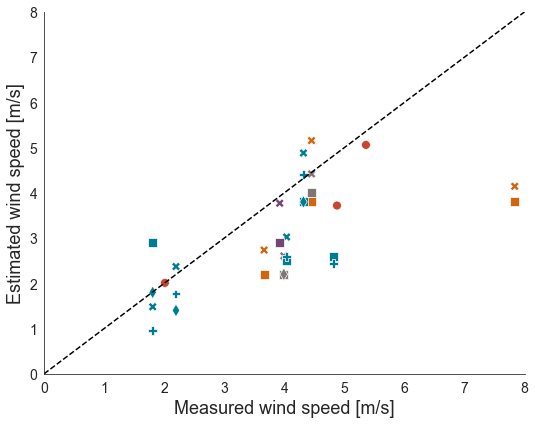

In [185]:
# Table S6
# Error statistics by team
selectedSatelliteResults.groupby('Team')['Error num'].agg(['count', 'min', 'mean', 'max', 'std'])

Wind speed parity chart

<Figure size 432x360 with 0 Axes>

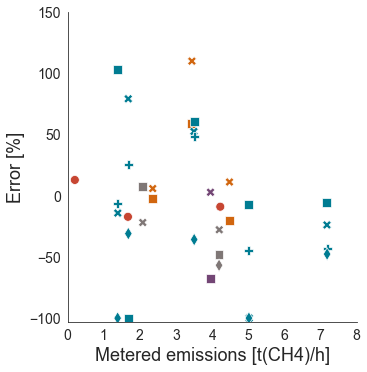

In [184]:
# Figure S3, wind speed parity chart


fig = plt.gcf()
#fig.set_size_inches(100, 8)

slctMarkers = markers.tolist()
slctColors = colors[[4, 1, 2, 0, 3]] # [[0, 3, 1, 2, 4]]
selectedSatelliteResults = satelliteResults

unblindingStage = 1 # 1 # 2
# selectedSatelliteResults = satelliteResults[satelliteResults['UnblindingStage']==unblindingStage]
StanfordPalette = sns.set_palette(sns.color_palette(slctColors))
# slctMarkers = markers[teamPos].tolist()

mainScatterPlot = sns.relplot(data=selectedSatelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100)], x='Wind_MPS_mean60', y='Wind speed est num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter', height=6, aspect=1.05)

lims = [0, 8]
plt.plot(lims, lims, '--', color='black')
sns.move_legend(mainScatterPlot, 'upper left', bbox_to_anchor=(0.14, 0.99))

plt.xlim(lims[0],lims[1]) #10000
plt.ylim(lims[0],lims[1]) #10000
mainScatterPlot._legend.remove()
# plt.legend(bbox_to_anchor=(0.01, 1), loc='upper left', borderaxespad=0)#, title_fontsize= 'large')
# mainScatterPlot._legend.set_frame_on(True)

plt.xlabel('Measured wind speed [m/s]', fontsize=18)
plt.ylabel('Estimated wind speed [m/s]', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rcParams["figure.figsize"] = (6,5)

sns.set_style("white") # "whitegrid
plt.tight_layout()
plt.savefig('/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite wind parity 20230130.pdf', format='pdf')
# plt.show()

Percent quantification error, Figure S2

In [206]:
# Figure S2, percent quantification error
# To produce Stage 2 estimates, switch unblindingStage from 1 to 2

fig = plt.gcf()

unblindingStage = 1 # 2
slctMarkers = markers.tolist()
slctColors = colors[[4, 1, 2, 0, 3]] # [[0, 3, 1, 2, 4]]
# selectedSatelliteResults = satelliteResults

sns.set_palette(sns.color_palette(slctColors)) # colors
selectedSatelliteResults = satelliteResults[satelliteResults['UnblindingStage']==unblindingStage]
# Percent change
pctScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Error num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter') #, legend=False)
# In situ wind
# pctScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Error in situ wind num', style='Team', hue='Satellite', s=80, kind='scatter') #, legend=False)
# sns.move_legend(mainScatterPlot, 'upper left', bbox_to_anchor=(0.8, 0.99))
sns.set_style("white")
plt.xlim(0,8)
plt.ylim(-103,150)
pctScatterPlot._legend.set_title("Satellite")
# mainScatterPlot._legend.draw_frame(True)
pctScatterPlot._legend.set_frame_on(True)
pctScatterPlot._legend.remove()
plt.xlabel('Metered emissions [t(CH4)/h]', fontsize=18)
plt.ylabel('Error [%]', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rcParams["figure.figsize"] = (6,5)
# ax.get_yaxis().set_major_formatter(
#     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# ax.get_xaxis().set_major_formatter(
#     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))# sns.set_style('darkgrid', {'legend.frameon':True})
# plt.savefig('/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity error stage 1 20230118.pdf', format='pdf')
# plt.savefig('/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity error stage 2 20230118.pdf', format='pdf')
plt.show()

,Error num 300,Error num 60,Error num 600
count,32.000000,32.000000,32.000000
mean,1.559186,1.535675,2.043903
std,45.370588,45.878814,44.913125
min,-67.603800,-67.469260,-68.111443
25%,-28.515522,-27.909010,-29.020234
50%,-6.525853,-7.834774,-5.659249
75%,16.072128,16.617495,17.377628
max,110.167867,113.263117,108.180112


Quantification error statistics by averaging period, Table S7

In [47]:
# Table S7
# Quantification error statistics by averaging period (in seconds)
unblindingStage = 1 # 1 # 2
# sns.set_palette(sns.color_palette(StanfordPalette)) # colors
satelliteResults['Error num 60'] = (satelliteResults['Estimate (KGH) num']*kg_per_t - satelliteResults['cr_kgh_CH4_mean60'])*100/satelliteResults['cr_kgh_CH4_mean60']
satelliteResults['Error num 600'] = (satelliteResults['Estimate (KGH) num']*kg_per_t - satelliteResults['cr_kgh_CH4_mean600'])*100/satelliteResults['cr_kgh_CH4_mean600']
selectedSatelliteErr = (satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100), ['Error num', 'Error num 60', 'Error num 600']])
selectedSatelliteErr.columns = ['Error num 300', 'Error num 60', 'Error num 600']
selectedSatelliteErr.describe()
# satelliteResults.loc[satelliteResults['Error num'] > -100, 'Error num'].describe()

(count    32.000000
 mean    -19.180828
 std      24.572177
 min     -51.515152
 25%     -38.559038
 50%     -21.697465
 75%      -3.102648
 max      60.353884
 dtype: float64,
 35.456389707464815)

In [42]:
# Table S7, continued
# Intra-quartile range
selectedSatelliteErr.describe().loc['75%', :] - selectedSatelliteErr.describe().loc['25%', :]

/Users/evansherwin/PycharmProjects/SatelliteTesting/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


(0.20606290853425394, 0.20404132459228086)

In [ ]:
# Table S7, continued
# Wind error statistics
unblindingStage = 1 # 1 # 2
# sns.set_palette(sns.color_palette(StanfordPalette)) # colors
selectedWindErrPct = 100*(satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage)  & (satelliteResults['Error num'] > -100),'Wind speed est num'] - satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100), 'Wind_MPS_mean60'])/\
                     satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100), 'Wind_MPS_mean60']
selectedWindErrPct.describe(), selectedWindErrPct.describe().loc['75%'] - selectedWindErrPct.describe().loc['25%']
# selectedWindErrPct

In [81]:
# % difference from stage 1 to stage 2
stage1Ests = np.array(satelliteResults.loc[(satelliteResults['UnblindingStage']==1), 'Estimate (KGH) num'])
stage2Ests = np.array(satelliteResults.loc[(satelliteResults['UnblindingStage']==2), 'Estimate (KGH) num'])
pctChange = (stage2Ests - stage1Ests)/stage1Ests
np.nanmean(pctChange), np.nanmedian(pctChange)
# stage2Ests

0.5625

Analysis of nonzero retrievals

In [51]:
nonzeroRetrievals = satelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0) & (satelliteResults['UnblindingStage']==unblindingStage)].shape[0]
nonzeroWithinCI = satelliteResults.loc[satelliteResults['within CI'] & (satelliteResults['UnblindingStage']==unblindingStage)].shape[0]
nonzeroWithinCI/nonzeroRetrievals
# nonzeroWithinCI
# nonzeroRetrievals

Satellite
GHGSat C2     1.00
Landsat 8     0.80
PRISMA        1.00
Sentinel-2    0.75
WV3           1.00
dtype: float64

/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/MethaneDistributions/ven37/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


<Figure size 800x400 with 0 Axes>

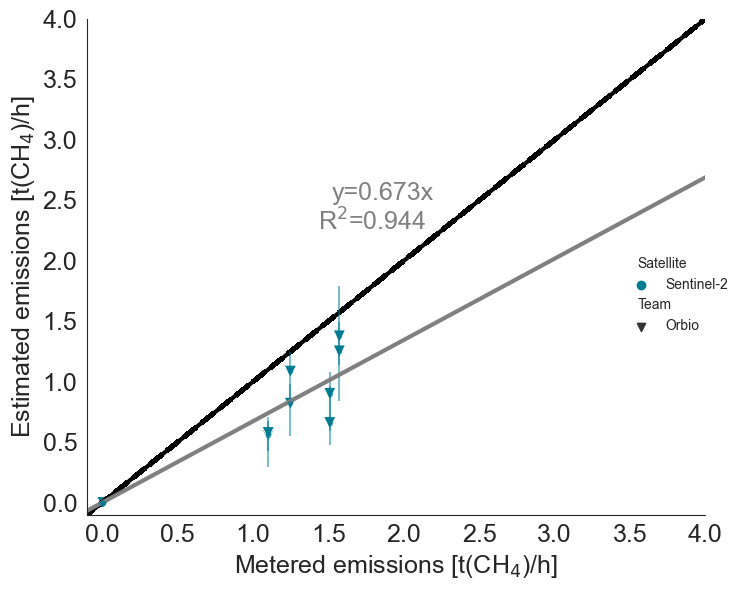

In [228]:
nonzeroRetrievalsBySatelliteTeam = satelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0) & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('OperatorSet').size()
nonzeroWithinCIBySatelliteTeam = satelliteResults.loc[satelliteResults['within CI'] & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('OperatorSet').size()
nonzeroWithinCIBySatelliteTeam/nonzeroRetrievalsBySatelliteTeam
# nonzeroWithinCI
# nonzeroRetrievalsBySatellite

In [145]:
nonzeroRetrievalsBySatellite = satelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0) & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('Satellite').size()
nonzeroWithinCIBySatellite = satelliteResults.loc[satelliteResults['within CI'] & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('Satellite').size()
nonzeroWithinCIBySatellite/nonzeroRetrievalsBySatellite

'#007C92'

In [ ]:
# fig = plt.gcf()
fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [10, 1]}, figsize=(5, 5))
unblindingStage = 2 # 1 # 2
stage = unblindingStage
satellite = 'All'
team = 'All'
selectedSatellite = satellite
selectedTeam = team
satellitedata = satelliteResults[satelliteResults['QC']=='OK']
axisbound = 4
linfitTextX = 2.2
linfitTextY = 2.5
qc = 'default'
includeReg='Yes'

# Filter for unblinding stage
# Exclude zeros
satellitedata = satellitedata[(satellitedata['UnblindingStage']==stage)]

# Apply QC criteria
if qc == 'default':
    satellitedata = satellitedata[satellitedata['QC']=='OK']
elif qc == 'lax':
    satellitedata = satellitedata[satellitedata['QC_lax']=='OK']

if satellite == 'All':
    if team == 'All':
        selectedSatelliteResults = satellitedata
        # selectedSatelliteResults = satellitedata[satellitedata['UnblindingStage']==unblindingStage]
if (satellite != 'All') & (team != 'All'):
    selectedSatelliteResults = satellitedata[(satellitedata['Satellite']==selectedSatellite) & (satellitedata['Team']==selectedTeam)]
    # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
elif satellite != 'All':
    selectedSatelliteResults = satellitedata[satellitedata['Satellite']==selectedSatellite]
    # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
elif team != 'All':
    selectedSatelliteResults = satellitedata[satellitedata['Team']==selectedTeam]
    # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Team']==selectedTeam)]

# Select out zeros
selectedSatelliteResultsZeros = selectedSatelliteResults[selectedSatelliteResults['Estimate (TPH) num'] == 0]

# Remove zeros from main data frame
selectedSatelliteResults = selectedSatelliteResults[selectedSatelliteResults['Estimate (TPH) num'] > 0]
# selectedSatellite = 'WV3' # 'PRISMA' # 'GHGSat C2' # 'Landsat 8' 'Sentinel-2' 'WV3'
# selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
# selectedTeam =  'Kayrros'# 'SRON' # 'Harvard' # 'LARS'# 'GHGSat'# 'Kayrros'
# selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Team']==selectedTeam)]
selectedSatelliteNames = selectedSatelliteResults['Satellite'].cat.categories# np.unique(selectedSatelliteResults['Satellite'])
selectedSatellitePos = np.in1d(satelliteNames, selectedSatelliteNames) #np.where(satelliteNames == selectedSatellite)[0][0] - 1
selectedSatelliteNames = selectedSatelliteNames.tolist()
selectedTeamNames = selectedSatelliteResults['Team'].cat.categories# np.unique(selectedSatelliteResults['Team'])
teamPos = np.in1d(teamNames, selectedTeamNames)
colors =  np.array(['#C74632', '#D1660F', '#007C92', '#7F7776', '#734675', 'black', 'pink', 'purple', 'green'])
slctColors = colors[selectedSatellitePos]

# slctColorsForErrorbars = colorsForErrorbars[selectedSatellitePos]
#                               blue      gray
colorsForErrorbars = np.array(['#007C92', '#7F7776', '#D1660F', '#734675', '#C74632', 'black', 'pink', 'saddlebrown', 'green'])
if (satellite=='All') & (team=='All'):
    slctColorsForErrorbars =  colorsForErrorbars # colors[[4, 2, 0, 1, 3, 5, 6, 7, 8]]
    StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbars))# StanfordPalette = sns.set_palette(sns.color_palette(slctColors))
elif (team!='All') & (satellite!='All'):
    slctColorsForErrorbarsInit = colorsForErrorbars[0]
    slctColorsForErrorbars =  slctColorsForErrorbarsInit# [[1, 3, 0, 2, 4]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
    StanfordPalette = sns.set_palette(sns.color_palette([slctColorsForErrorbarsInit]))
elif (team=='Kayrros'):
    slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
    slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[0, 1, 2, 3, 4, 5, 6]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
    StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
elif (team=='LARS'): # elif (team=='LARS') & (stage==1):
    slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
    slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[0, 1, 2, 4, 3]] # slctColorsForErrorbarsInit[[0, 1, 2, 4, 3]]
    StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
# elif (team=='LARS') & (stage==2):
#     slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
#     slctColorsForErrorbars =  slctColorsForErrorbarsInit[[0, 1, 2, 3]] # slctColorsForErrorbarsInit[[0, 1, 2, 4, 3]]
#     StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
elif (team=='MAXAR'):
    slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
    slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[0, 1, 2, 3, 4]]# [[1, 3, 0, 2, 4]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
    StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
elif (team=='NJU'):
    slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
    slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[0, 1, 2, 3, 4, 5, 6, 7]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
    StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
elif (team=='Orbio'):
    slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
    slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
    StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
elif (team=='GHGSat'):
    slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
    slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[1, 0]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
    StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
else:
    slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
    slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
    StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
# if (team == 'SRON') | (team == 'Harvard') | (satellite != 'All'):
#     slctColorsForErrorbars = np.append(slctColors[1:], slctColors[0])# slctColors# np.append(slctColors[1:], slctColors[0])
# else: slctColorsForErrorbars = colorsForErrorbars[selectedSatellitePos]

# slctColorsForErrorbars = colorsForErrorbars[selectedSatellitePos]

# For main plots, LARS, and Kayrros
 # np.append(slctColors[1:], slctColors[0])# slctColors# np.append(slctColors[1:], slctColors[0])  # colorsForErrorbars[selectedSatellitePos]
# For individual satellites and teams
# slctColorsForErrorbars = np.append(slctColors[1:], slctColors[0])# slctColors# np.append(slctColors[1:], slctColors[0])

subsetMarkers = np.array(['X', 's', 'P', 'd', 'o', 'v'])
if (satellite=='All') & (team=='All'):
    slctMarkers = markers[teamPos].tolist()
else:
    slctMarkers = subsetMarkers[teamPos].tolist()

# Construct the main scatter plot
mainScatterPlot = sns.scatterplot(data=selectedSatelliteResults, x='gas_tph_mean', y='Estimate (TPH) num', style='Team', hue='Satellite', markers=slctMarkers, legend=False, s=80, ax=axes[0]) #, legend=False) # 'logged KGH', palette='tab10'
axes[0].tick_params(labelbottom=False, labelsize=14)
axes[0].set_xlabel("")
# mainScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
# mainScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
# In situ wind
# mainScatterPlot = sns.relplot(data=satelliteResults[satelliteResults['UnblindingStage']==2], x='cr_kgh_CH4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
lims = [0, 8.000] # [-0.100, 8.000]
lims_df = pd.DataFrame(data={'x':lims, 'y':lims})
sns.lineplot(data=lims_df, x='x', y='y', color='black', ax=axes[0])
# sns.move_legend(mainScatterPlot, 'lower right', bbox_to_anchor=(0.99, 0.14)) # sns.move_legend(mainScatterPlot, 'upper left', bbox_to_anchor=(0.14, 0.99))
# mainScatterPlot._legend.set_frame_on(True)

# plt.errorbar(x=satelliteResults['Estimate (kgh) mean'], y=satelliteResults['Estimate (KGH) num'], xerr=meteredErrorbarsFlat, yerr=satelliteResults['Estimate (KGH) num']*0.1, fmt='.')
# satelliteResults['Estimate (kgh) P97_5'] - satelliteResults['Estimate (kgh) mean']
# sns.set_style("white")
# plt.axhline(1000, ls='--', linewidth=3, color='red')
# plt.plot([0,0], [8000,8000])
# mainScatterPlot.ax_joint.plot([0,0], [8000,8000], '-', linewidth = 2)

# # mainScatterPlot._legend.set_title("Satellite")
# mainScatterPlot._legend.set_title(None)
# mainScatterPlot._legend.remove()

# Comment out to remove legend
# plt.legend(bbox_to_anchor=(0.01, 1), loc='upper left', borderaxespad=0, fontsize=12)#, title_fontsize= 'large')

# plt.legend(fontsize= 60)
# mainScatterPlot._legend.draw_frame(True)
# plt.xlabel('Metered emissions [t(CH$_4$)/h]', fontsize=18)
# plt.xlabel("", fontsize=18)
# plt.ylabel('Estimated emissions [t(CH$_4$)/h]', fontsize=18)
# plt.xticks(fontsize=18)
# # plt.xticks([])
# plt.yticks(fontsize=18)

colorCounter = 0
# shapes = itertools.cycle(['o', 'x', 's', '+', 'd'])
for satelliteName in selectedSatelliteNames:
    selectedData = selectedSatelliteResults.loc[(selectedSatelliteResults['Satellite'] == satelliteName)]
    if len(selectedData) == 0:
        colorCounter = colorCounter + 1 # If there are no data points for the selected satellite, just advance the color counter
    else:
        slctMeteredErrorbars = selectedData[['xCILower', 'xCIUpper']] #.sub(selectedData['cr_kgh_CH4_mean300'], axis='index')
        slctMeteredErrorbarsFlat = np.concatenate(np.array(slctMeteredErrorbars)).reshape(len(slctMeteredErrorbars), 2).transpose()
        # selectedErrors = satelliteResults.loc[(satelliteResults['Satellite'] == satellite)]
        if (team == 'Orbio') | (satellite != 'All'):
            slctColor = slctColorsForErrorbars[0]
        else:
            slctColor = slctColorsForErrorbars[colorCounter] #
            # slctColor = slctColorsForErrorbars[[2, 3, 1, 8, 4, 5, 0, 6, 7]][colorCounter] #

        # print(satellite)
        # print(slctColor)

        # plt.errorbar(selectedData['Estimate (kgh) mean'],
        #             selectedData['Estimate (KGH) num'], xerr=slctMeteredErrorbarsFlat, yerr=selectedData['Estimate (KGH) num']*0.1, fmt='.', color=slctColor)
        axes[0].errorbar(selectedData['gas_tph_mean'], selectedData['Estimate (TPH) num'],
                     xerr=np.array([selectedData['xCILower']*xCImult, #*xCImult
                                    selectedData['xCIUpper']*xCImult]), #*xCImult
                     # xerr=np.array([np.abs(selectedData['cr_kgh_CH4_lower300'] -
                     #                       selectedData['cr_kgh_CH4_mean300']), #*xCImult
                     #                np.abs(selectedData['cr_kgh_CH4_upper300'] -
                     #                       selectedData['cr_kgh_CH4_mean300'])]), #*xCImult
                     yerr=np.array([np.abs(selectedData['Flux est CI low'] -
                                           selectedData['Estimate (TPH) num']),
                                    np.abs(selectedData['Flux est CI high'] -
                                           selectedData['Estimate (TPH) num'])]), fmt='.', color=slctColor, alpha=0.5)
                                           # selectedData['Estimate (TPH) num'])]), fmt='.', color=slctColor, alpha=0.5)
        colorCounter = colorCounter + 1

# plt.rcParams["figure.figsize"] = (6,5)
#sns.set(rc={"figure.figsize":(10, 5)})
sns.set_style("ticks") # "whitegrid" "white"

# Linear regression for satellite data, forced zero intercept
if (includeReg=='Yes'):
    regData = selectedSatelliteResults.loc[(selectedSatelliteResults['Estimate (TPH) num'] > 0), ['gas_tph_mean', 'Estimate (TPH) num']]
    regData.columns = ['x', 'y']
    model = smf.ols(formula="y ~ x + 0", data=regData)
    # model = smf.ols(formula="y ~ x", data=regData)
    result = model.fit()
    # result.summary()
    results_as_html_main = result.summary().tables[1].as_html()
    results_as_html_r2 = result.summary().tables[0].as_html()
    # results_as_html
    results_main = pd.read_html(results_as_html_main, header=0, index_col=0)[0]
    results_r2_and_more = pd.read_html(results_as_html_r2, header=0, index_col=0)[0]
    results_r2 = results_r2_and_more.columns[2]
    results_coeff = results_main['coef'][0]

    x_domain = np.array([lims[0], lims[1]]) # .reshape(-1,1)
    y_pred = x_domain*results_coeff
    xy_df = pd.DataFrame(data={'x':x_domain, 'y':y_pred})

    sns.lineplot(data=xy_df, x='x', y='y', color='gray', dashes=[2, 2], ax=axes[0]) # , style='-'
    # plt.plot(x_domain, y_pred, '-', color='gray', linewidth=3)
    axes[0].text(linfitTextX, linfitTextY, 'y='+str(np.round(results_coeff, 3))+'x', fontsize=18, color='gray', rotation=0, ha='right') # -63
    axes[0].text(linfitTextX - 0.05, linfitTextY - 0.25, 'R$^2$='+results_r2, fontsize=18, color='gray', rotation=0, ha='right') # -63
# For in situ wind case
# plt.text(6750, 5000, 'y='+str(np.round(results_coeff, 3))+'x', fontsize=18, color='gray', rotation=0, ha='right') # -63
# plt.text(6600, 4500, 'R$^2$='+results_r2, fontsize=18, color='gray', rotation=0, ha='right') # -63

# Set axis bounds for top panel
axes[0].set_xlim(0,axisbound) #10000 -0.100
axes[0].set_ylim(0,axisbound) #10000 -0.100


# plt.tight_layout()
# plt.savefig(pathlib.PurePath(foldername, filename), format='png')
# plt.show()

# Save strip of zeros

zerosPlot = sns.scatterplot(data=selectedSatelliteResultsZeros, x='gas_tph_mean', y='Estimate (TPH) num', style='Team', hue='Satellite', markers=slctMarkers, s=80, alpha=0.4, legend=False, ax=axes[1]) # 'logged KGH', palette='tab10' height=0.3, aspect=17
detect_plot_strip_width = 0.01
axes[1].set_xlim(0,axisbound)
# plt.gcf().patch.set_edgecolor('black')
axes[1].set_ylim(-detect_plot_strip_width, detect_plot_strip_width)
# plt.xlabel('Metered emissions [t(CH$_4$)/h]', fontsize=14)
plt.xticks(fontsize=14)
# zerosPlot.set(ylabel=None)
sns.set_style("ticks")
axes[1].set_yticklabels(['', 0.0, ''], fontsize=16)
# zerosPlot.tick_params(left=False)
# zerosPlot.set(yticklabels=[])

# Turn off axis lines and ticks of the big subplot
# Adapted From https://stackoverflow.com/questions/6963035/how-to-set-common-axes-labels-for-subplots
# axes.spines['top'].set_color('none')
# axes.spines['bottom'].set_color('none')
# axes.spines['left'].set_color('none')
# axes.spines['right'].set_color('none')
# axes[0].tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# axes[1].tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

# Set axis labels
axes[1].set_xlabel('Metered emissions [t(CH$_4$)/h]', size=16)
axes[0].set_ylabel('Estimated emissions\n[t(CH$_4$)/h]', size=16)
axes[1].set_ylabel('Non-\ndetects', size=16)

# plt.tight_layout()
# plt.savefig(pathlib.PurePath(foldername, 'Zeros' + filename), format='png')
plt.show()


In [ ]:
# sns.lineplot(data=xy_df, x='x', y='y')
# xy_df = pd.DataFrame(data={'x':x_domain, 'y':y_pred}, index=np.arange(len(x_domain)))
# x_domain, y_pred
# sns.lineplot(data=xy_df)
# (np.array([lims[0], lims[1]]).reshape(-1,1)).shape
# axisbound
# selectedSatelliteResultsZeros.loc[selectedSatelliteResultsZeros['Estimate (TPH) num'] > 0, ['Team', 'Estimate (TPH) num']]
zerosPlot = sns.scatterplot(data=selectedSatelliteResultsZeros, x='gas_tph_mean', y='Estimate (TPH) num', style='Team', hue='Satellite', markers=slctMarkers, s=80, alpha=0.4, legend=False)

Generate wind roses for selected data points

In [25]:
# def plot_windrose(start_t, stop_t):
start_t = datetime.strptime('11/18/22 18:20', '%m/%d/%y %H:%M')
stop_t = datetime.strptime('11/18/22 18:25', '%m/%d/%y %H:%M')
""" Plot a wind rose for wind speed and direction values given a start and stop time.
Inputs:
  - start_t, stop_t are datetime objects

Outputs: A wind rose for the selected period
"""

if start_t.date() != stop_t.date():
    # End function if start and end t are on different dates
    print(
        'Do not attempt to calculate average flow across multiple dates. Please consider a new start or end time.')
    # return
elif start_t.date() > stop_t.date():
    print('Start time is after end time. Time for *you* to do some debugging!')
    # return
else:
    # Load data
    file_name = start_t.strftime('%m_%d')
    # use subclass Path (instead of PurePath) because we need to check if the file exists
    file_path = pathlib.Path('03_wind_data', f'{file_name}.csv')

    # Check if we have a meter file for the input date
    if not file_path.is_file():
        # If file does not exist, we did not conduct releases on that day.
        # Set all values of results_summary to zero or np.nan
        results_summary = {
            'average_windspeed': np.nan,
            'average_winddirection': np.nan,
            'stdev_windspeed': np.nan,
            'stdev_winddirection': np.nan,
        }
    else:
        # If file exists, calculate flow rate summary info:
        # Select data for averaging
        wind_data = pd.read_csv(file_path, parse_dates=['datetime'])
        time_ave_mask = (wind_data['datetime'] >= start_t) & (wind_data['datetime'] <= stop_t)
        average_period = wind_data.loc[time_ave_mask].copy()
        length_before_drop_na = len(average_period)

        # Drop rows with NA values
        average_period.dropna(axis='index', inplace=True, thresh=7)
        length_after_drop_na = len(average_period)
        dropped_rows = length_before_drop_na - length_after_drop_na
        if dropped_rows > 0:
            print(f'Number of rows that were NA in the average period ({start_t} to {stop_t}): {dropped_rows}')
    average_period
    # windrose.plot_windrose(average_period, )


NameError: name 'average_period' is not defined

In [29]:
file_path #.is_file()
# windrose.plot_windrose()

PosixPath('03_wind_data/11_18.csv')